# **데이터 불러오기 & 전처리** 



In [1]:
from google.colab import files
uploaded = files.upload()

Saving vgames2.csv to vgames2 (2).csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('vgames2.csv')
df = df.drop('Unnamed: 0', axis = 1 ) # 불필요 칼럼 제거
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [3]:
df.info()
'''
[해야할 것]
1. null값 처리 ('year' - 271, 'genre' - 50, 'publisher' - 58) - 숫자형인 year만 처리하자.
2. data type 변경 ('year' int로 바꾸고 '*_sales' float로 바꾸기)
3. 각 칼럼 특성 및 특이 관측치 확인 (특히 sales 쪽 데이터 의미, 특이점 확인 필수, year도)
>> NA_sales에 230K 이런 것도 있고, JP_sales에는 0M, other_sales엔 80K 이런 것도 있음. 나머지 데이터도 뭘 나타내는지 파악 필요함. 출고량이라는데 출고량이 왜 소수지?
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


"\n[해야할 것]\n1. null값 처리 ('year' - 271, 'genre' - 50, 'publisher' - 58) - 숫자형인 year만 처리하자.\n2. data type 변경 ('year' int로 바꾸고 '*_sales' float로 바꾸기)\n3. 각 칼럼 특성 및 특이 관측치 확인 (특히 sales 쪽 데이터 의미, 특이점 확인 필수, year도)\n>> NA_sales에 230K 이런 것도 있고, JP_sales에는 0M, other_sales엔 80K 이런 것도 있음. 나머지 데이터도 뭘 나타내는지 파악 필요함. 출고량이라는데 출고량이 왜 소수지?\n"

In [4]:
### Sales 칼럼 단위가 대체 뭘까? ###
condition = (df['Name'] == 'Saki: Achiga-Hen Portable')
df.loc[condition]
## 'https://www.vgchartz.com/game/75642/saki-achiga-hen-episode-of-side-a-portable/cheats' 여기서 실제 판매량 찾아보니 단위 million 인듯.

#하나 더 보자. 
condition = (df['Name'] == 'Rainbow Islands: Revolution')
df.loc[condition]
## https://192-168-1-1pass.com/games/rainbow-islands-revolution/ 단위 Million 맞음.

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0


In [5]:
#### Year 칼럼 처리 ###
#null값 일괄 0으로 바꾸고, 칼럼 Dtype integer로 변경
df = df.fillna({'Year':0})
df[['Year']] = df[['Year']].astype(int)

# 'Year'에 연도 제대로 표시안된 데이터 있음.
'''
ax = sns.relplot(x = 'Year', y = 'Total_sales', hue = 'Genre', data = df) - 그래프로 확인함.

condition = (df['Year'] < 1950) & (df['Year'] > 0)
year_df = df[condition]
year_df

보면 2000년대 이상의 경우 뒤 두 자리 중 0을 제외한 숫자만 나오고,
1900년대의 경우 앞의 19가 제거된 상태로 나와있다. 규칙이 있으니 넣어주기만 하면 된다.
'''

def right_year(n):
  if n > 0 and n < 22: #이거 잘해라 큰일난다. 0이랑 이런거 빼야 한다. 
    n = n + 2000
  elif n > 22 and n < 100:
    n = n + 1900
  else: pass
  return n

df['Year'] = df['Year'].apply(right_year)
df['Year'] #완료

0        2008
1        2009
2        2010
3        2010
4        2010
         ... 
16593    2006
16594    2005
16595    2015
16596    2013
16597    1996
Name: Year, Length: 16598, dtype: int64

In [6]:
#### Sales 칼럼 처리 ###
'''
1. K 글자가 있으면 K를 제거하고 남은 숫자에 0.001 곱한다 (예시) 320k = 0.32)
2. M 글자가 있으면 그 글자만 제거한다.
3. float 타입으로 모두 변경한다. 
'''

#K, M 문자 제거/단위 맞추기 & float로 변환 함수
def to_int(n):
  if n.endswith('K'):
    n = float(n.replace('K', ""))
    n = n * 0.001
  elif n.endswith('M'):
    n = float(n.replace('M', "")) 
  else:
    n = float(n)
  return n

# Sales 칼럼 함수 적용
df['NA_Sales'] = df['NA_Sales'].apply(to_int)
df['EU_Sales'] = df['EU_Sales'].apply(to_int)
df['JP_Sales'] = df['JP_Sales'].apply(to_int)
df['Other_Sales'] = df['Other_Sales'].apply(to_int)

df.info() # 완료!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16598 non-null  int64  
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.1+ MB


In [7]:
# Total_sales 칼럼 추가
df['Total_sales'] = df['NA_Sales'] + df['EU_Sales'] +	df['JP_Sales'] + df['Other_Sales']
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


# **OVERVIEW**

---


**우리가 다음 분기에 개발할 게임의 컨셉은 `가장 잘 팔리는 게임`입니다.**
<br>
<br>
**'잘 팔리는 게임'** 을 만들기 위해 우리는 두 가지 방향으로 접근할 수 있습니다.
- 예전의 PUBG가 배틀그라운드를 개발할 때 그러했듯 새로 열리는 시장을 선점하기 위해 달릴 것인가?
- 이미 잘 팔리고 있는 시장에서 경쟁 우위를 노릴 것인가?

<br>

**이 둘 중에 저는 데이터 분석가의 입장에서 후자에 대해 말씀드려보고자 합니다.** <br>
앞으로 공유드릴 저의 분석 방향에 대한 감을 잡는데 도움이 되실 것이라 생각해, 그 이유에 대해 짧게 말씀드려보겠습니다.
- 흔히 새로 열리는 시장을 두드리는 건 비즈니스적으로 매우 Risky한 전략입니다. 그 새로운 시장이, 그 안의 고객이 어떤 특성을 지녔는지도 불문명하며, 열리는 줄 알았던 시장이 그대로 사라져버리는 경우도 비일비재하기 때문입니다. 이는 검증된 데이터가 없다는 말이기도 합니다. 시장의 전체 파이가 어느 정도일지 뚜껑을 열어보기 전까지는 알 수 없습니다. 10인 줄 알고 들어갔는데, 알고보니 1짜리 시장일 수도 있는거죠. 저희가 생존의 확률을 높이기 위해서는 이미 시장성이 검증된 운동장에서 최대한 많은 파이를 가져오는 것을 추구하는 것이 더 낫다고 생각합니다.
- 그럼 이런 궁금증이 드실 수도 있겠습니다. '이미 형성된 시장은 기존 플레이어들이 넘쳐날텐데 거기서 어떻게 파이를 가져올 거야?' 저는 이 질문에 대해 이미 여러분이 잘 알고 계실 만한 말로 답을 드려보고자 합니다.
  - 흔히 엔터테인먼트 비즈니스는 **`대박 아니면 쪽박`**이라고 말합니다. 여기서 고객의 취향에 중간은 없습니다. 완전 빠져들거나, 아니면 아예 무관심합니다. 자기가 정말 좋아하는게 있는데도, 여가 시간을 적당히 좋아하는 것에 투자할 이유가 없기 때문입니다. 
  - 인기있는 장르가 아니더라도 게임을 아주 잘 만들면 고객들이 좋아해줄 수도 있지 않겠냐고요? 그럴 수도 있습니다. 하지만 아닐 가능성이 더 높습니다. **`제작의 실패와 흥행의 실패는 별개다.`** 라는 말이 있습니다. 아무리 잘 만든 게임이어도 대중성이 없다면 흥행에는 실패할 수 있습니다. (앵그리버드는 게임 퀄리티가 아주 훌륭해서 대박을 친걸까요?)
  - 게임 산업에서는 '포화시장'이라는 의미가 다른 산업군과 다르다고 생각합니다. 시장이 이미 과열되어 있는 상태라도 새로운 플레이어가 고객 다수의 취향을 잘 맞춘 좋은 게임을 만든다면 파이를 독식할 수 있는 곳이 현재 우리가 몸담고 있는 이곳의 중요한 특성입니다. 

물론 성공할 수 있는 '그 지점'을 찾기란 매우 어려운 일입니다. 그래서 과거 데이터를 분석해보는 것이 중요하다고 생각합니다. 우리가 가장 잘 팔리는 게임을 만들기 위해서 고객이 무엇을 좋아하는지를 알아야 하기 때문입니다.
<br> 
<br> 

**이번 분석의 개요를 간단히 말씀드리면,**
  1. Game Market Trends를 분석합니다.
    - 고객의 돈이 어디에 몰리고 있는지, 게임은 얼마나 출시되고 있는지, 장르별, 지역별로 어떤 추이가 있는지, 가장 잘 팔리는 게임은 무엇인지를 살펴봅니다.
    - 통계적인 상세분석보다는 여러 데이터 시각화를 통해 게임 시장에 대한 대략적인 감을 잡는 것을 목표로 합니다. 
  2. Go-to-market 전략을 제안합니다.
    - 1번을 통해 어느 지역으로, 어떤 장르의 게임을 개발하는 것이 좋을지 제가 세운 가설과 검증을 통해 우리가 개발해야할 게임이 무엇인지에 대한 말씀을 드립니다.
    

그럼 시작합니다!

# **What are the Market Trends?** 
(EDA, 대략적인 트렌드 파악 및 가설 수립을 위함)

---




## 데이터셋 개요

In [8]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25


In [9]:
# 대략적인 구조 파악
print('[Name value number]\n',df['Name'].value_counts())
print('--------------------')
print('[장르별 게임 수] \n',df['Genre'].value_counts())
print('--------------------')
print('[Publisher별 게임 수] \n',df['Publisher'].value_counts())
print('--------------------')
print('[Platform 별 게임 수] \n',df['Platform'].value_counts())

[Name value number]
 Need for Speed: Most Wanted            12
FIFA 14                                 9
Ratatouille                             9
Madden NFL 07                           9
LEGO Marvel Super Heroes                9
                                       ..
Saki: Achiga-Hen Portable               1
Shining Force Feather                   1
Model * Oshare Audition: Dream Girl     1
Twisted Metal 2                         1
Rainbow Islands: Revolution             1
Name: Name, Length: 11493, dtype: int64
--------------------
[장르별 게임 수] 
 Action          3305
Sports          2341
Misc            1734
Role-Playing    1483
Shooter         1308
Adventure       1280
Racing          1243
Platform         884
Simulation       865
Fighting         847
Strategy         680
Puzzle           578
Name: Genre, dtype: int64
--------------------
[Publisher별 게임 수] 
 Electronic Arts                 1351
Activision                       975
Namco Bandai Games               932
Ubisoft      

## **Sales Trends (Total)**
고객의 돈이 얼마나 모이나? <br>
1. 출시 연도별 판매량 변화 (sum, mean)
2. 출시 게임 수 변화

Text(0.5, 1.0, 'Sum')

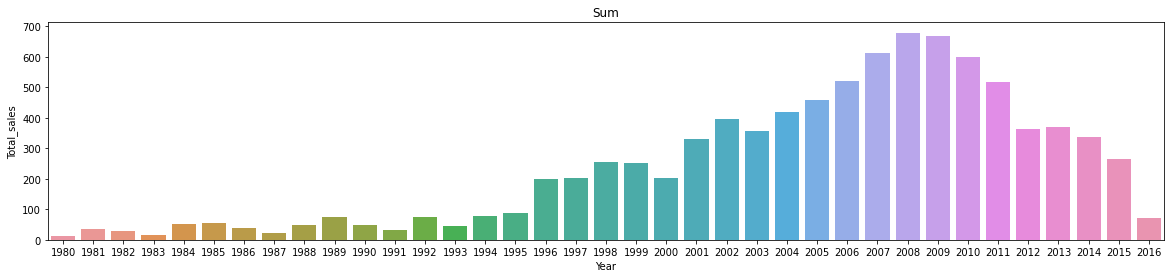

In [10]:
### 출시 연도별 판매량 변화 (sum) ###

condition = (df['Year'] != 0) & (df['Year'] <= 2016)
sales_df = df[condition]
sales_df #year = 0 제외

sales_df = sales_df.groupby('Year').sum()
sales_df = sales_df.reset_index()

#시각화
plt.figure(figsize = (20,4))
ax = sns.barplot(x = 'Year', y = 'Total_sales',data = sales_df)
plt.title('Sum')

[Text(0, 0.5, 'Release_count'), Text(0.5, 0, 'Year')]

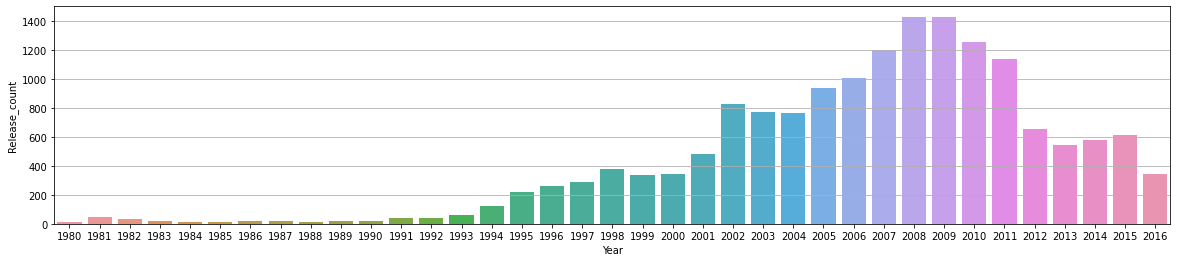

In [11]:
# 연도별 출시 게임 수 추이
condition = (df['Year'] != 0)  & (df['Year'] <= 2016)
rls_count = df[condition]

rls_count = rls_count.groupby(['Year']).count()
rls_count = rls_count.reset_index()
rls_count = rls_count.iloc[:, :2]

#시각화
plt.figure(figsize = (20,4))
plt.grid()
ax = sns.barplot(x = 'Year', y = 'Name', data = rls_count)
ax.set(xlabel = 'Year', ylabel = 'Release_count')

Text(0.5, 1.0, 'mean')

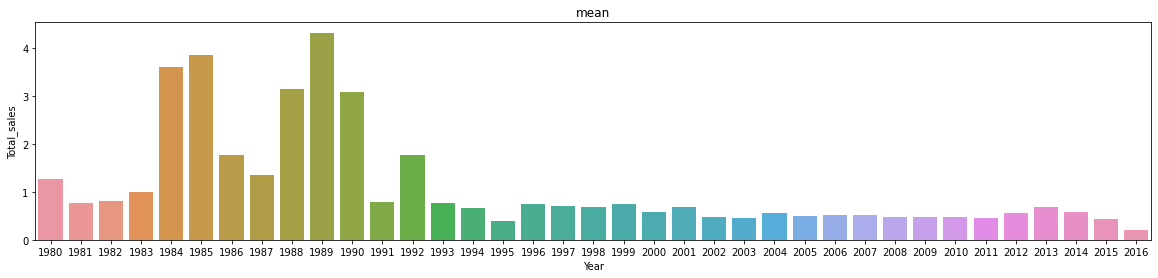

In [12]:
### 출시 연도별 판매량 변화 (mean) ###
condition = (df['Year'] != 0) & (df['Year'] <= 2016)
sales_df = df[condition]
sales_df #year = 0 제외

sales_df = sales_df.groupby('Year').mean()
sales_df = sales_df.reset_index()

#시각화
plt.figure(figsize = (20,4))
ax = sns.barplot(x = 'Year', y = 'Total_sales',data = sales_df)
plt.title('mean')

**확인할 수 있는 것**
1. 출시 연도별 `판매량 합계`, `출시 게임 수`는 양의 상관관계를 보이며, 2000년대 이후 동시에 증가하여 2007 ~ 2011년에 Peak를 찍었다.
2. 2011년 이후에는 감소하는데 그럼 시장이 쪼그라들었냐? 이 데이터셋만 보고 판단할 수는 없다. 물론 판매량은 최근 출시한 게임일수록 시간이 지나며 더 늘어날 수도 있다. 하지만 그렇다고 해도 게임 출시 수 자체도 줄어든 것은 시사하는 바가 분명 있다.
  - **데이터셋의 Platform을 보면 모바일이 없다. 전체 판매량이 줄어드는 시기가 스마트폰의 보급 시기와 맞물리는 걸로 봐선 수요가 모바일로 대거 이동한 것으로 볼 수 있다. (고점 대비 50% 가까이 빠졌다.)**
  - **게임 출시 수로봐도 그 시기에 줄어드는 걸로 봐선 모바일 강세 흐름은 더 커질 수도 있을 듯하다.**
3. 출시연도별 `판매량 평균`을 보면 1990년 이전에는 출시 게임 수 자체가 적어서 그런지 평균 판매량 자체가 상당히 높게 나왔다. (우리의 관심은 최근이기 때문에 이 사실 자체가 큰 의미가 있지는 않다)

## **Sales Trends (지역별)**
어느 지역이 잘 팔리나? <br>
1. 출시 연도별 판매량 변화 (sum, mean)

In [13]:
df.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
count,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,1973.285818,0.264667,0.146652,0.077782,0.048063,0.537164
std,255.726684,0.816683,0.505351,0.309291,0.188588,1.555151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


**출시 연도 무관, 규모 면에서 북미 시장이 가장 매력적일 것으로 예상된다. (그 다음 EU)**
- 표준편차가 제일 큰 것보니 성공과 실패이 편차가 더 클 것이긴 하지만, 나머지 수치들이 상대적으로 높게 나온다.

좀 더 자세히 살펴보자.

!! Y축 범례 다른 것에 유의하세요 !! 



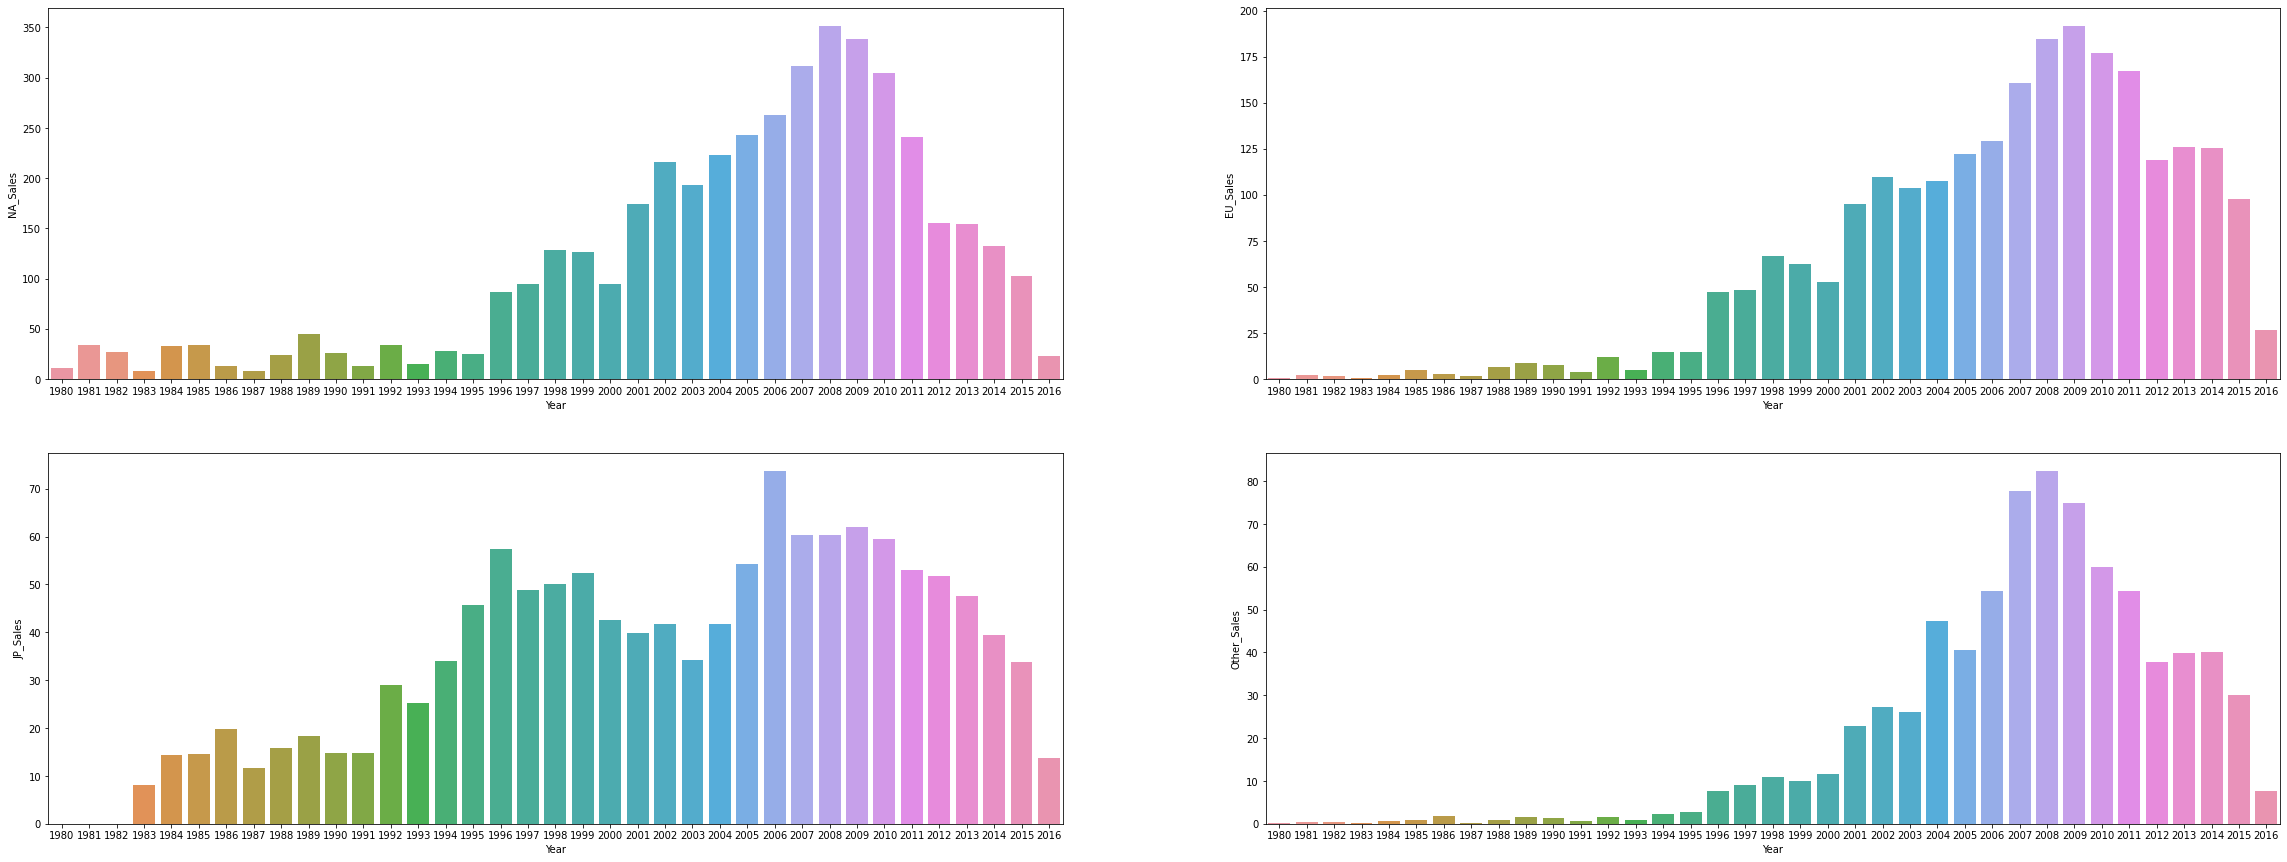

In [14]:
### 출시 연도별 판매량 변화 (sum) ###

condition = (df['Year'] != 0)  & (df['Year'] <= 2016)
sales_df = df[condition]
sales_df #year = 0 제외

sales_df = sales_df.groupby('Year').sum()
sales_df = sales_df.reset_index()
sales_df

#시각화
fig = plt.figure(figsize = (40,15))

area01 = fig.add_subplot(2, 2, 1)
area02 = fig.add_subplot(2, 2, 2)
area03 = fig.add_subplot(2, 2, 3)
area04 = fig.add_subplot(2, 2, 4)

print('!! Y축 범례 다른 것에 유의하세요 !! \n')
sns.barplot(x = 'Year', y = 'NA_Sales', ax = area01 , data = sales_df)
sns.barplot(x = 'Year', y = 'EU_Sales', ax = area02 , data = sales_df)
sns.barplot(x = 'Year', y = 'JP_Sales', ax = area03 , data = sales_df)
sns.barplot(x = 'Year', y = 'Other_Sales',ax = area04 , data = sales_df)

!! Y축 범례 다른 것에 유의하세요 !! 



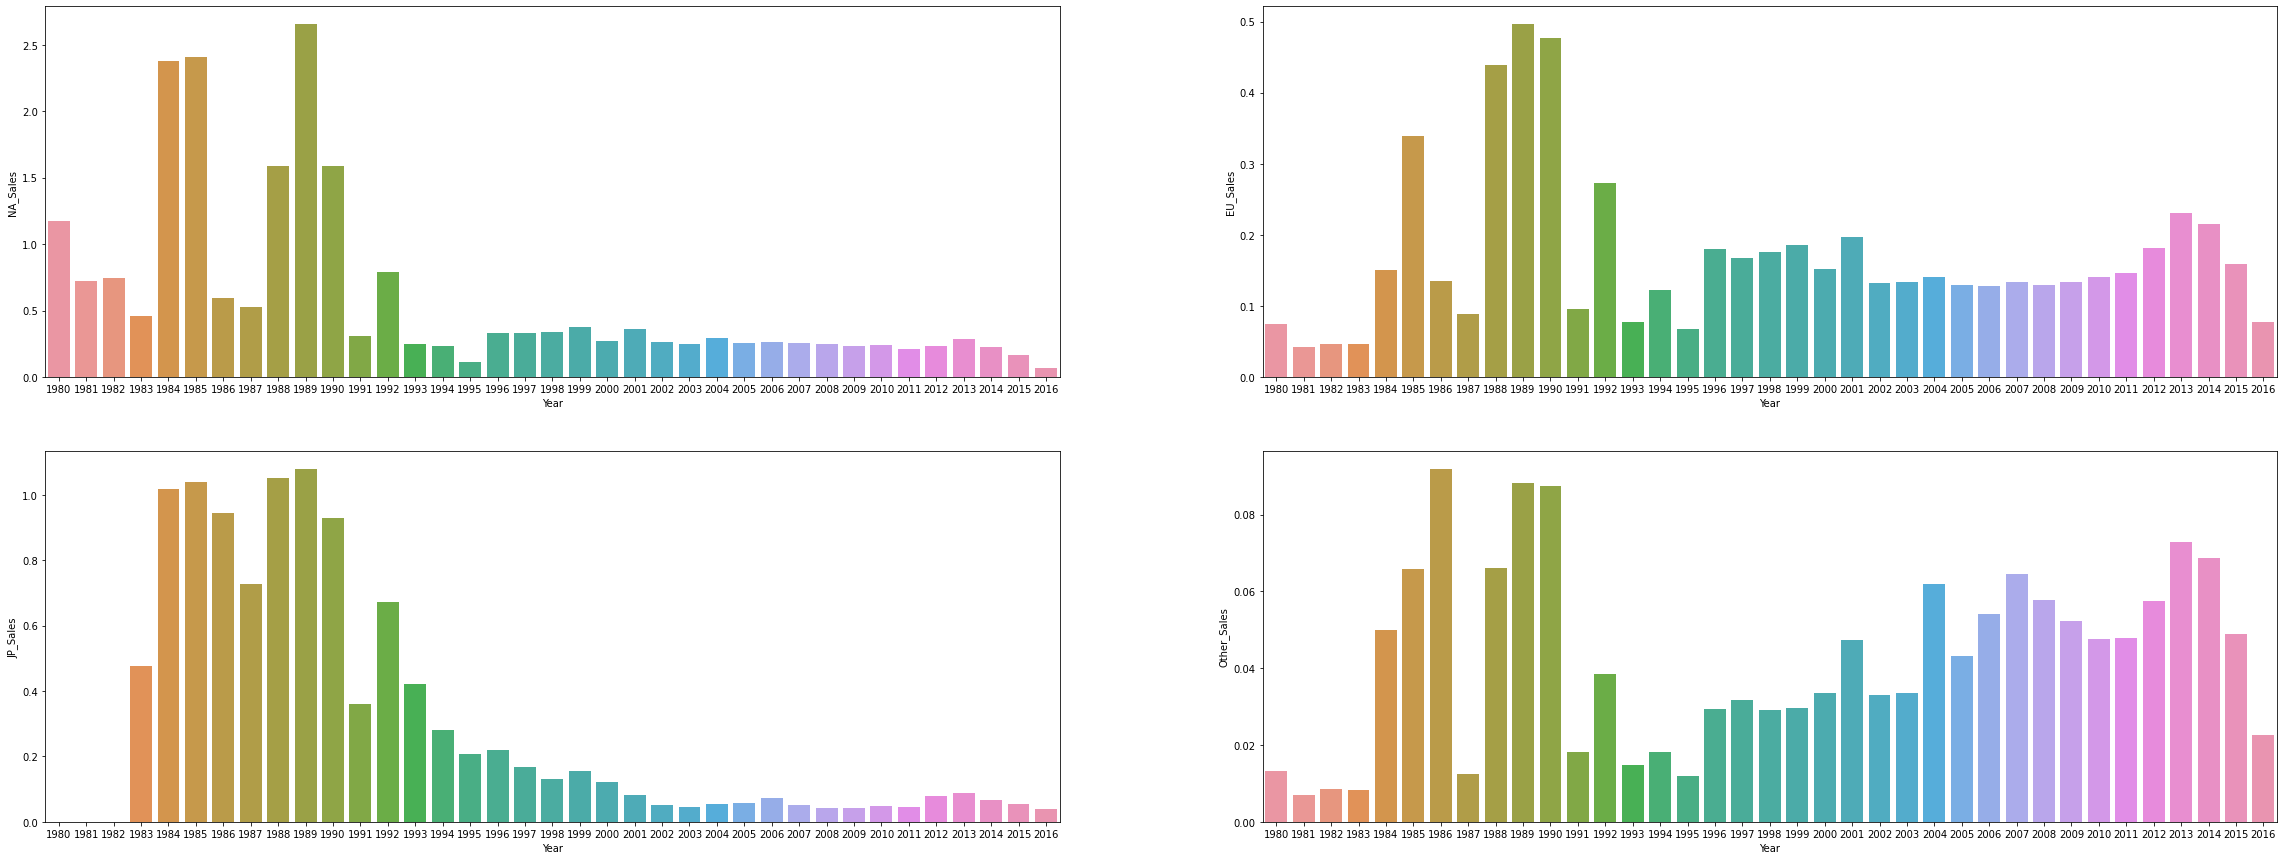

In [15]:
### 출시 연도별 판매량 변화 (mean) ###

condition = (df['Year'] != 0)  & (df['Year'] <= 2016)
sales_df = df[condition]
sales_df #year = 0 제외

sales_df = sales_df.groupby('Year').mean()
sales_df = sales_df.reset_index()
sales_df

#시각화
fig = plt.figure(figsize = (40,15))

area01 = fig.add_subplot(2, 2, 1)
area02 = fig.add_subplot(2, 2, 2)
area03 = fig.add_subplot(2, 2, 3)
area04 = fig.add_subplot(2, 2, 4)

print('!! Y축 범례 다른 것에 유의하세요 !! \n')
sns.barplot(x = 'Year', y = 'NA_Sales', ax = area01 , data = sales_df)
sns.barplot(x = 'Year', y = 'EU_Sales', ax = area02 , data = sales_df)
sns.barplot(x = 'Year', y = 'JP_Sales', ax = area03 , data = sales_df)
sns.barplot(x = 'Year', y = 'Other_Sales',ax = area04 , data = sales_df)

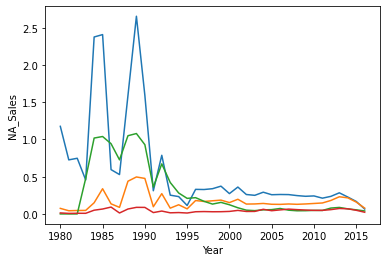

In [16]:
#mean 추가 참고용 그래프
ax = sns.lineplot(x = 'Year', y = 'NA_Sales', data = sales_df) #blue line
ax = sns.lineplot(x = 'Year', y = 'EU_Sales',  data = sales_df) #yellow line
ax = sns.lineplot(x = 'Year', y = 'JP_Sales',  data = sales_df) #green line
ax = sns.lineplot(x = 'Year', y = 'Other_Sales',  data = sales_df) #red line

**확인할 수 있는 것**
- 전체 판매량 추이 보면 북미가 2011년 이후에 상당히 많이 빠진다. (고점대비 약 55% 정도)
  - **모바일로 특히 더 많이 이동하는건가?**
  - EU는 그나마 고점대비 35% 정도 감소.
  - 일본은 특이하게도 완만하게 감소한다. 아날로그의 국가라서 그런가.. 😮
- 평균 판매량 추이를 보면, **북미, EU는 판매량으로 봤을 때는 의미가 여전히 있다고는 할 수 있다. 우리가 게임을 잘 만들면 가장 많이 팔 수 있는 지역이라고 할 수도 있겠다.**

## **Genre Release Trends** 
어떤 장르의 게임이 가장 많이 나오고 있나? 



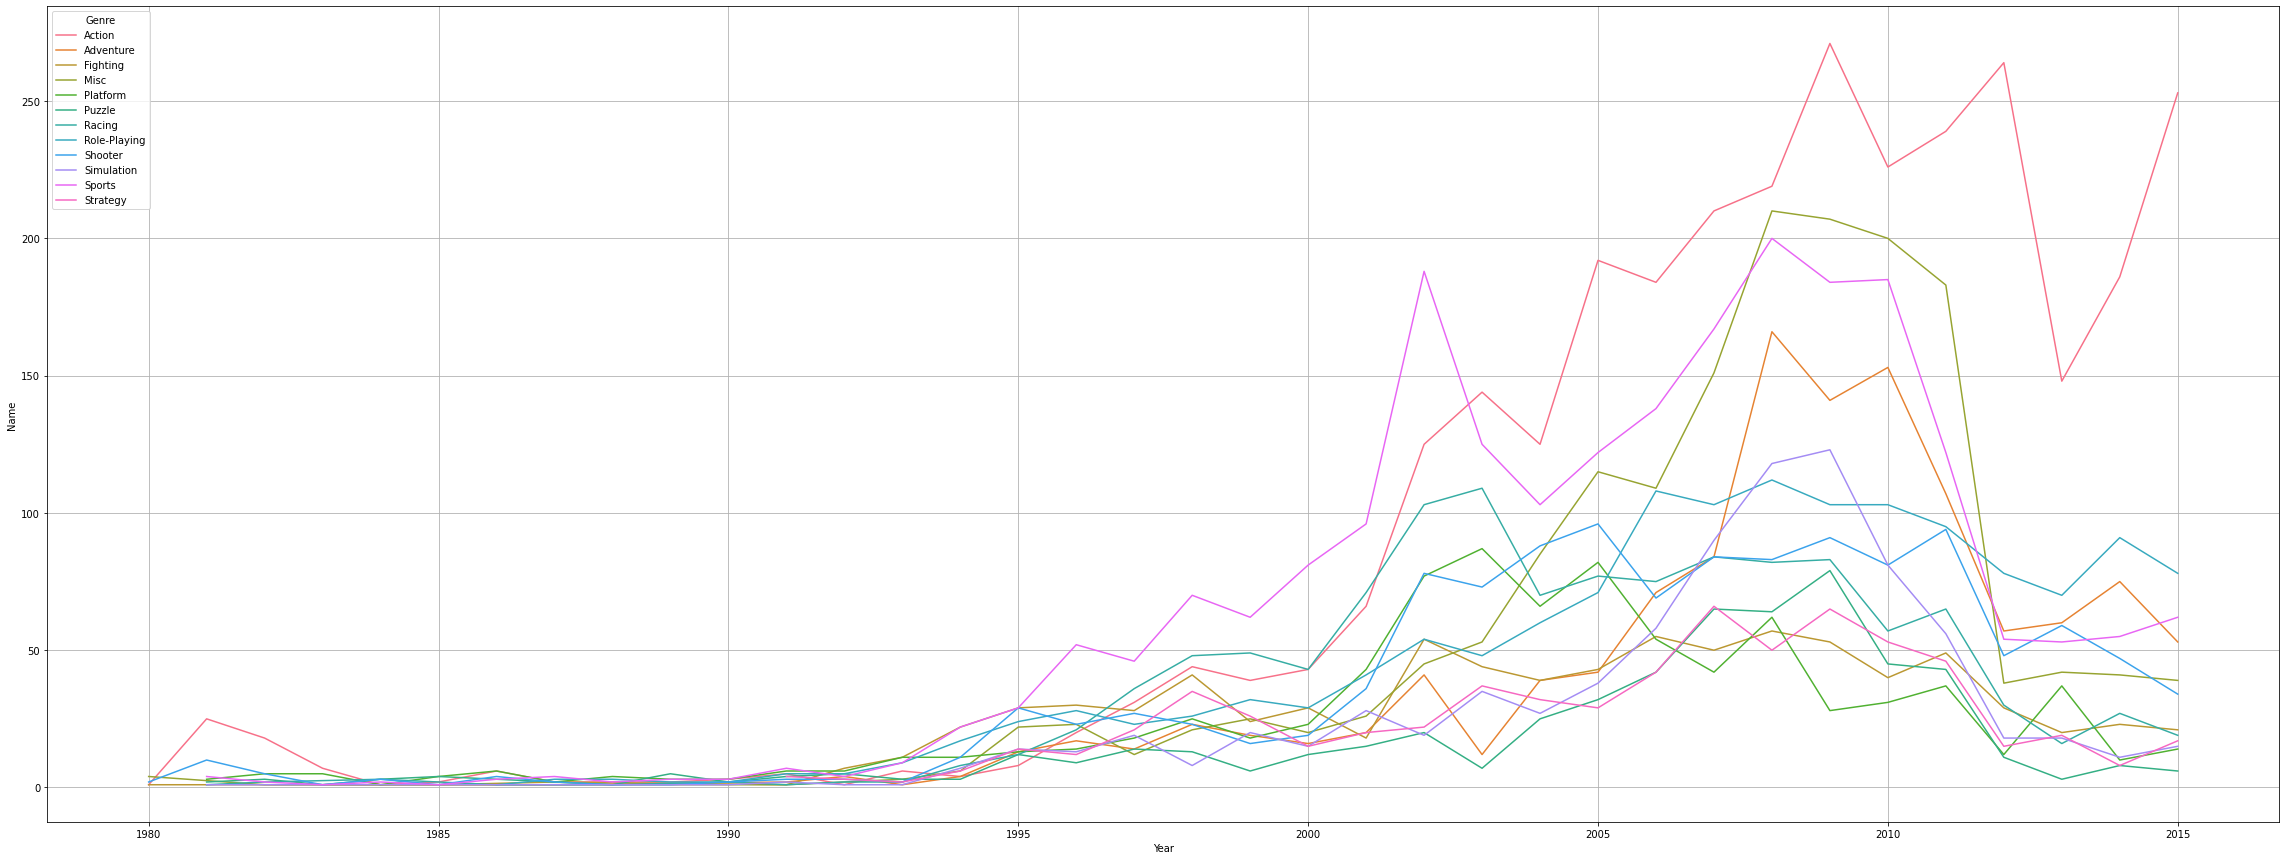

In [17]:
#출시 연도, 장르별 출시 게임 수(count) - !! Total !!
condition = (df['Year'] > 0) & (df['Year'] < 2016)
genre_df = df[condition]
genre_df #year = 0 제외, 2015년까지만

genre_df = genre_df.groupby(['Genre','Year']).count()
genre_df = genre_df.reset_index()
genre_df = genre_df.iloc[:, :3]

#시각화
fig = plt.figure(figsize = (40,15))
plt.grid()
sns.lineplot(x = 'Year', y = 'Name', hue = 'Genre', data = genre_df)

**Action 게임이 엄청나게 나오고 있다**<br>
(하지만 우리에게 뭐가 많이 나오고 있냐보다는 뭐가 많이 팔리고 있느냐가 더 중요하므로 이건 참고만)

## **Genre Sales Trends (Total)** 
어떤 장르가 가장 잘 팔릴까?



In [18]:
### 대략적인 파악 ###
# genre 별 Total_sales 
genre_total_sales = df.groupby('Genre').Total_sales.sum()
print('[장르별 총 판매량] \n', genre_total_sales)
print('====================================')

# genre 별 Total_sales per game - 게임 수가 많으면 판매량도 자연스레 높아질 가능성이 있으므로 총 판매량을 게임 수로 나누는 것.
genre_count = df.groupby('Genre').count()
genre_count = genre_count.iloc[:, 1]

genre_total_sales_pergame = df.groupby('Genre').Total_sales.sum() / genre_count
print('[장르별 판매량 per game] \n', genre_total_sales_pergame)

print('====================================')
print('[장르별 게임 수] \n', genre_count) 

[장르별 총 판매량] 
 Genre
Action          1741.32
Adventure        238.47
Fighting         448.40
Misc             799.72
Platform         830.23
Puzzle           243.47
Racing           727.79
Role-Playing     905.03
Shooter         1035.90
Simulation       391.49
Sports          1327.04
Strategy         174.84
Name: Total_sales, dtype: float64
[장르별 판매량 per game] 
 Genre
Action          0.526874
Adventure       0.186305
Fighting        0.529398
Misc            0.461200
Platform        0.939174
Puzzle          0.421228
Racing          0.585511
Role-Playing    0.610270
Shooter         0.791972
Simulation      0.452590
Sports          0.566869
Strategy        0.257118
dtype: float64
[장르별 게임 수] 
 Genre
Action          3305
Adventure       1280
Fighting         847
Misc            1734
Platform         884
Puzzle           578
Racing          1243
Role-Playing    1483
Shooter         1308
Simulation       865
Sports          2341
Strategy         680
Name: Platform, dtype: int64


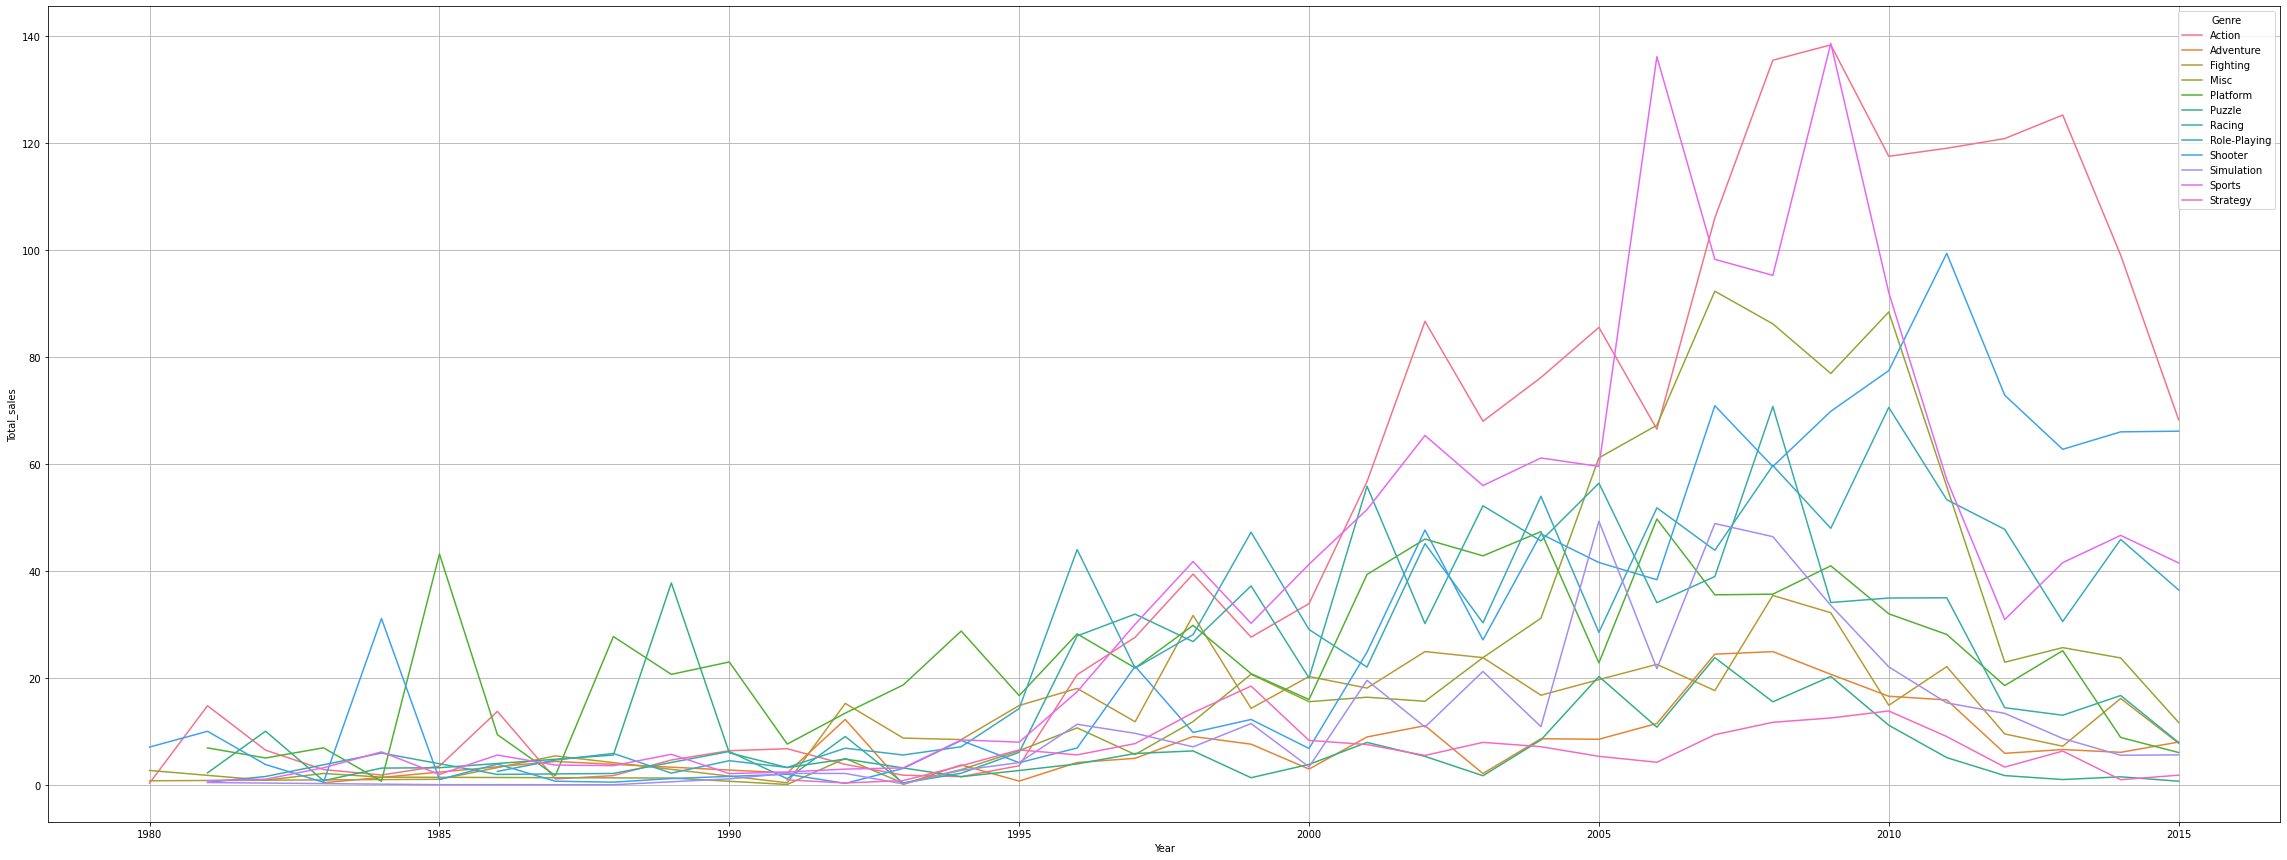

In [19]:
### 출시 연도, 장르별 판매량 추이 (sum) ###
condition = (df['Year'] > 0) & (df['Year'] < 2016)
genre_total_sales = df[condition]

genre_total_sales = genre_total_sales.groupby(['Genre', 'Year']).sum()
genre_total_sales = genre_total_sales.reset_index()
genre_total_sales = genre_total_sales[['Genre', 'Year', 'Total_sales']]
genre_total_sales

#시각화
fig = plt.figure(figsize = (40,15))
plt.grid()
sns.lineplot(x = 'Year', y = 'Total_sales', hue = 'Genre', data = genre_total_sales)

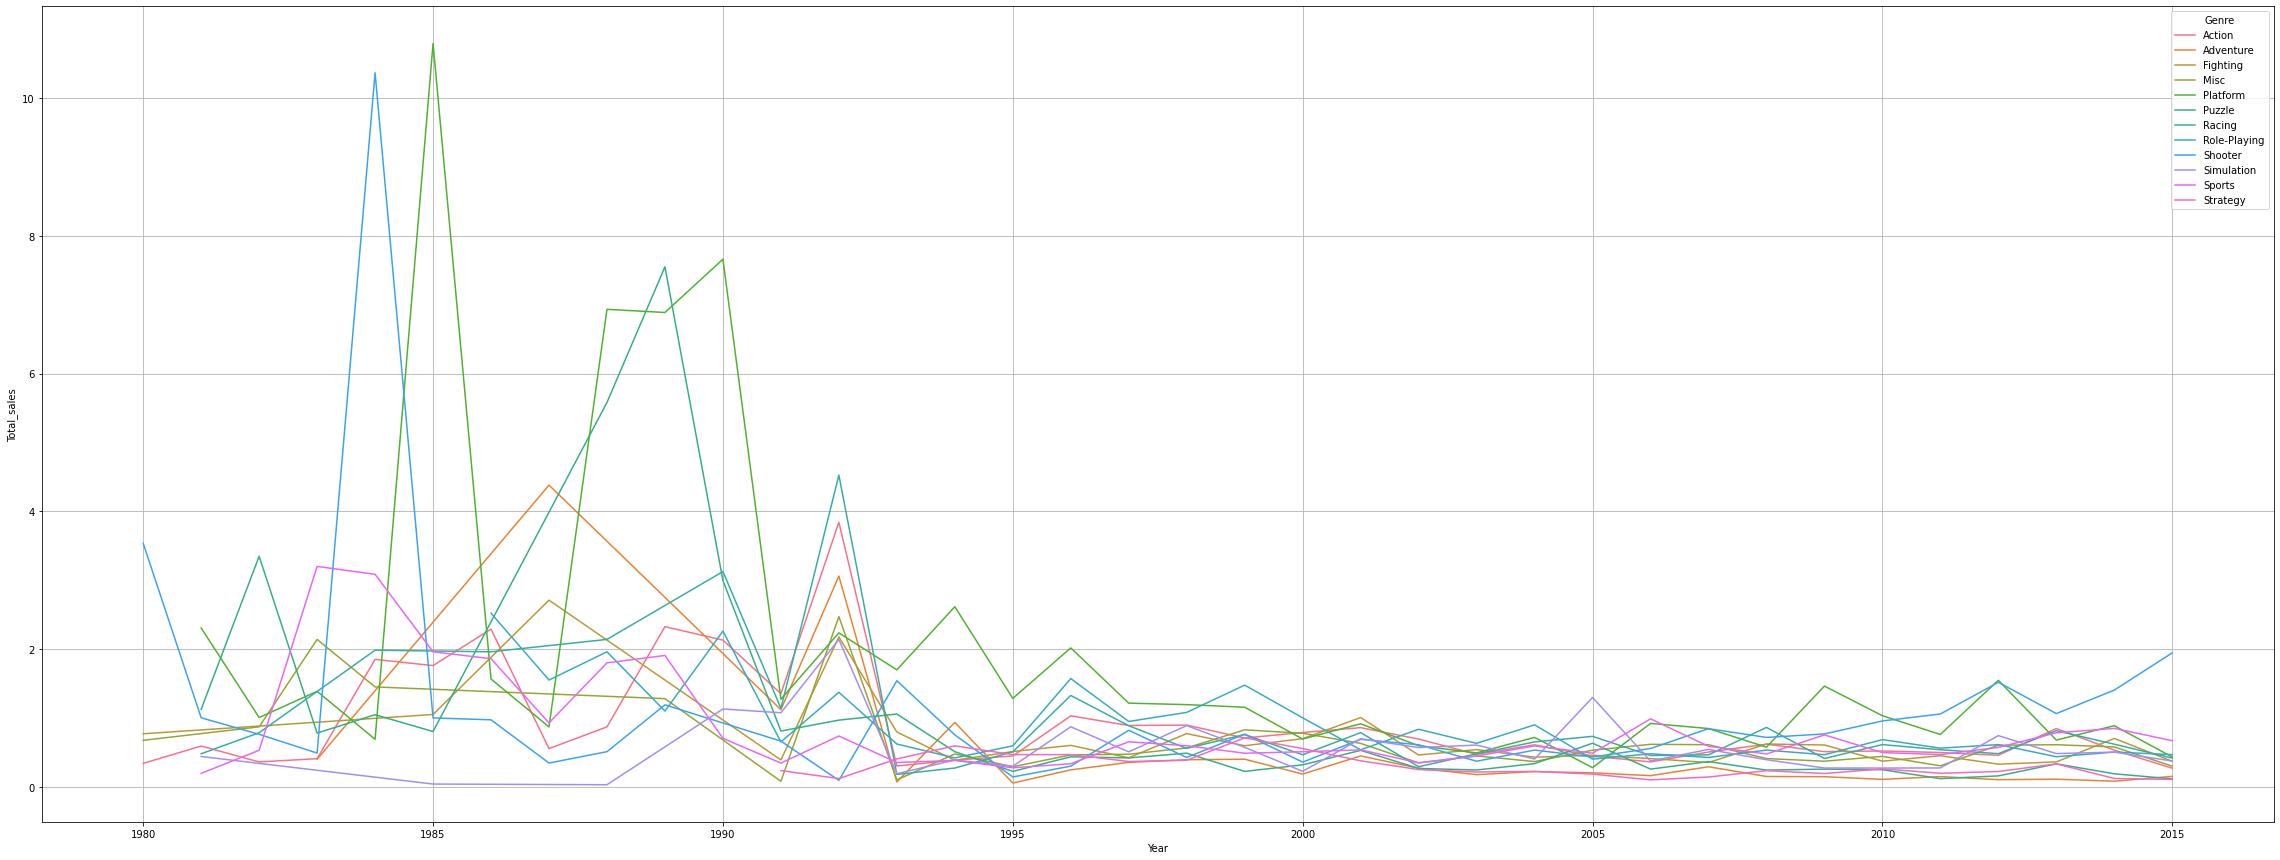

In [20]:
### 출시 연도, 장르별 판매량 추이 (mean) ###
condition = (df['Year'] > 0) & (df['Year'] < 2016)
genre_total_sales = df[condition]

genre_total_sales = genre_total_sales.groupby(['Genre', 'Year']).mean()
genre_total_sales = genre_total_sales.reset_index()
genre_total_sales = genre_total_sales[['Genre', 'Year', 'Total_sales']]

#시각화
fig = plt.figure(figsize = (40,15))
plt.grid()
sns.lineplot(x = 'Year', y = 'Total_sales', hue = 'Genre', data = genre_total_sales)

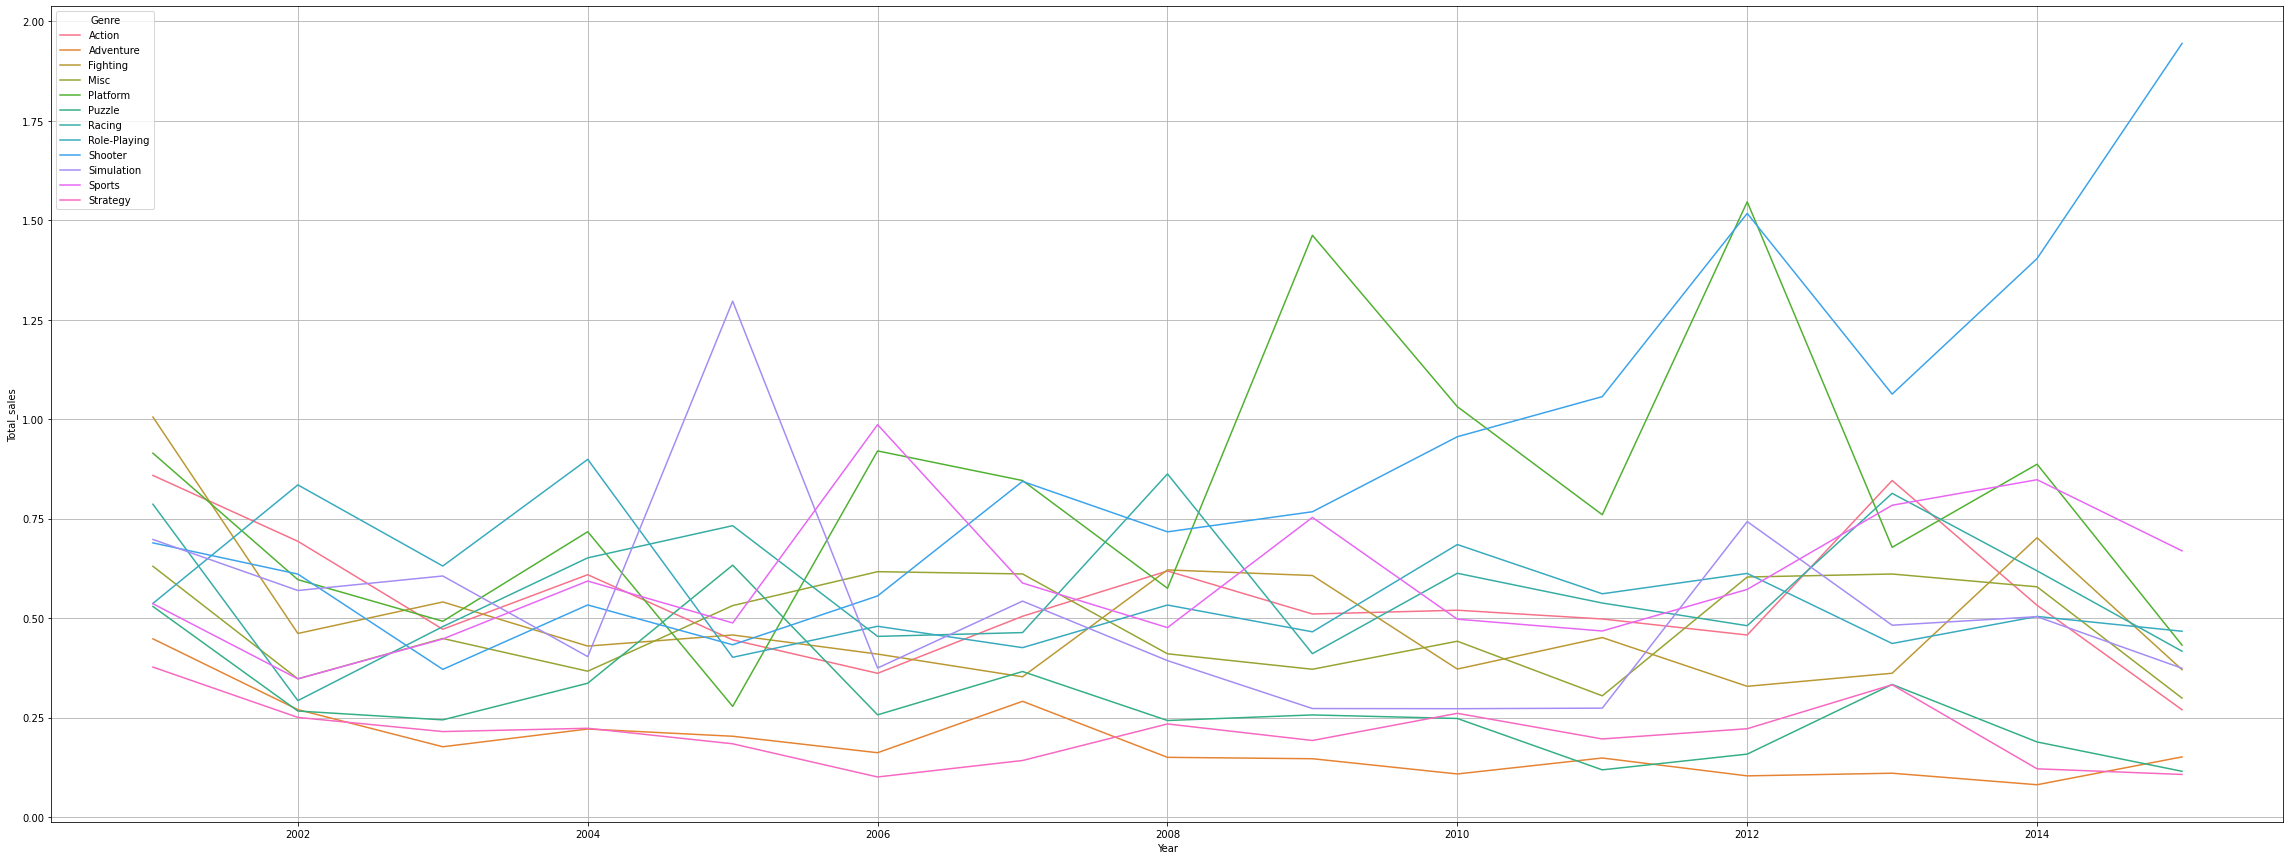

In [21]:
### 출시 연도, 장르별 판매량 추이 (mean) ### - 2000~2015
condition = (df['Year'] > 2000) & (df['Year'] < 2016)
genre_total_sales = df[condition]

genre_total_sales = genre_total_sales.groupby(['Genre', 'Year']).mean()
genre_total_sales = genre_total_sales.reset_index()
genre_total_sales = genre_total_sales[['Genre', 'Year', 'Total_sales']]

#시각화
fig = plt.figure(figsize = (40,15))
plt.grid()
sns.lineplot(x = 'Year', y = 'Total_sales', hue = 'Genre', data = genre_total_sales)

**알수 있는 것**
1. `Action` - 출시 게임 수는 늘었는데, 판래량 합계는 되려 떨어졌다. (해당 장르 제외해야 할 수도 있겠다)
2. 평균 판매량으로 보면 `Shooter`가 꾸준히 증가 추세이다.

지역별로 어떤지도 봐야 나중에 어느 시장 노릴 것인지 판단을 세울 수 있을 듯.

## **Genre Sales Trends (지역별)** 
지역별로 선호하는 장르가 다를까?



!! Y축 범례 다른 것에 유의하세요 !! 



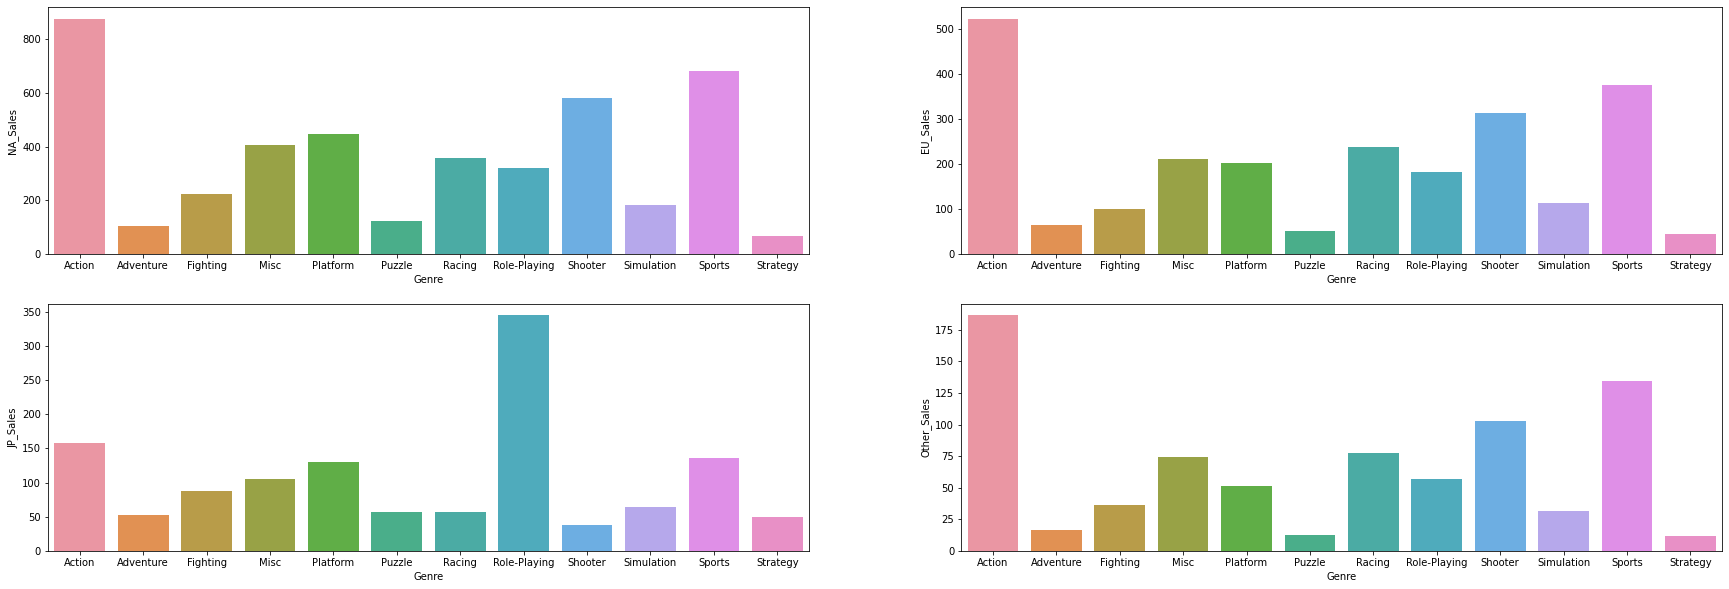

In [22]:
### 장르별 누적 판매량이 지역별로 어떻게 나타나는가? (sum) ###

#데이터 준비
genre_df = df.groupby('Genre').sum()
genre_df = genre_df.reset_index()
genre_df = genre_df.drop(['Year'], axis = 1) #year 불필요하니 drop
genre_df

#시각화
fig = plt.figure(figsize = (30,10))

area01 = fig.add_subplot(2, 2, 1)
area02 = fig.add_subplot(2, 2, 2)
area03 = fig.add_subplot(2, 2, 3)
area04 = fig.add_subplot(2, 2, 4)

print('!! Y축 범례 다른 것에 유의하세요 !! \n')
sns.barplot(x = 'Genre', y = 'NA_Sales', ax = area01 , data = genre_df)
sns.barplot(x = 'Genre', y = 'EU_Sales', ax = area02 , data = genre_df)
sns.barplot(x = 'Genre', y = 'JP_Sales', ax = area03 , data = genre_df)
sns.barplot(x = 'Genre', y = 'Other_Sales',ax = area04 , data = genre_df)

`NA, EU, Other 총 판매량(sum)` TOP 3 (공통)
- Action, Sports, Shooter 
(Action은 게임 수가 제일 많기도 함)

일본은 특이하게 `Role-Playing`이 엄청 높네.

**NA/EU - `Shooter` or `Sport`?**

!! Y축 범례 다른 것에 유의하세요 !! 



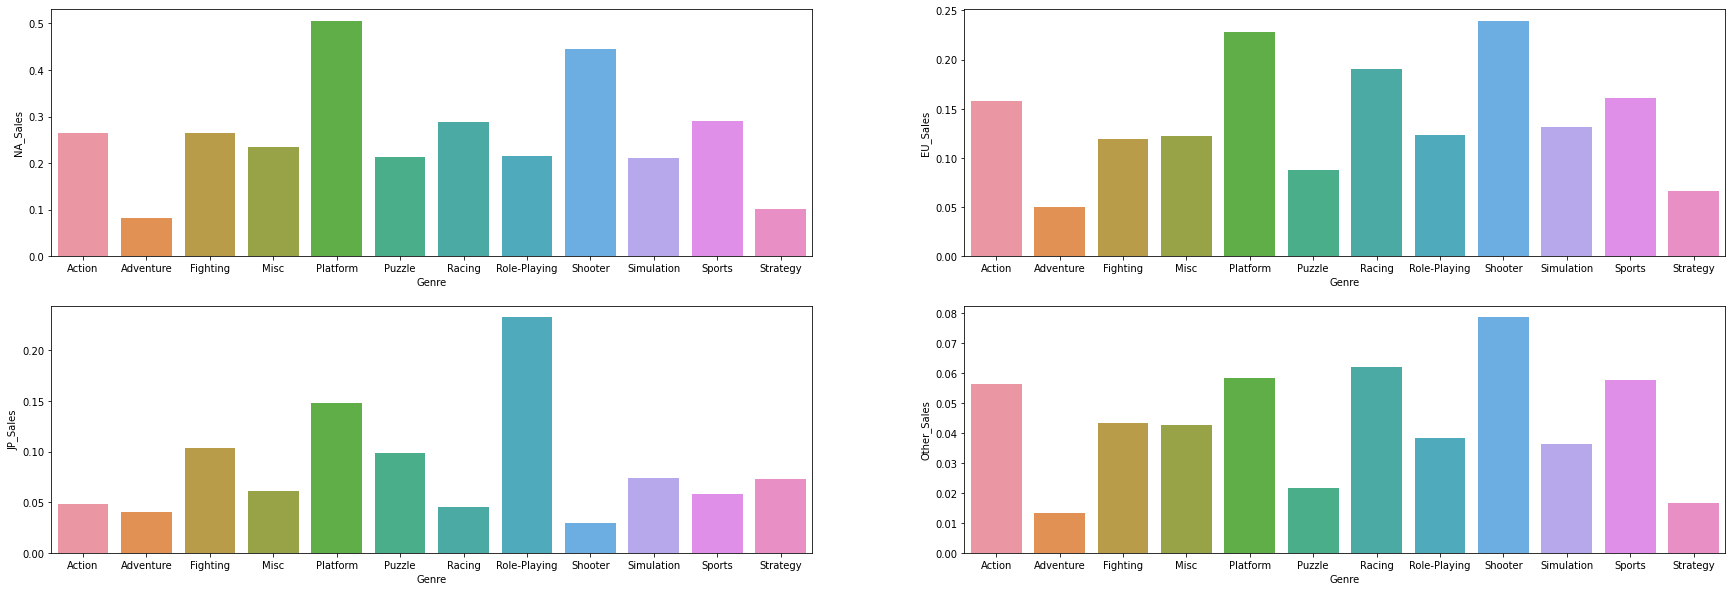

In [23]:
### 장르별 평균 판매량이 지역별로 어떻게 나타나는가? (mean) ###

#데이터 준비
genre_df_mean = df.groupby('Genre').mean()
genre_df_mean = genre_df_mean.reset_index()
genre_df_mean = genre_df_mean.drop(['Year'], axis = 1) #year 불필요하니 drop

#시각화
fig = plt.figure(figsize = (30,10))

area01 = fig.add_subplot(2, 2, 1)
area02 = fig.add_subplot(2, 2, 2)
area03 = fig.add_subplot(2, 2, 3)
area04 = fig.add_subplot(2, 2, 4)

print('!! Y축 범례 다른 것에 유의하세요 !! \n')
sns.barplot(x = 'Genre', y = 'NA_Sales', ax = area01 , data = genre_df_mean)
sns.barplot(x = 'Genre', y = 'EU_Sales', ax = area02 , data = genre_df_mean)
sns.barplot(x = 'Genre', y = 'JP_Sales', ax = area03 , data = genre_df_mean)
sns.barplot(x = 'Genre', y = 'Other_Sales',ax = area04 , data = genre_df_mean)

`NA, EU 총 판매량(mean)` TOP
- Platform/Shooter 정도가 공통적으로 높음. 나머지는 비등한 것들 다수 있음.
  - platform은 총 판매량에서는 아닌데 평균에서는 눈에 띈다는 점이 궁금하네.
- EU는 racing도 인기가 많긴 함. 
- Other는 Shooter가 가장 높고 Racing, Sport, Plaform, Action 비등.

역시 일본은 Rola-playing이 압도적으로 잘 팔리고, 다음으로 Platform, Fighting/Puzzle로 다른 지역과는 차이를 보인다.
<br>
<br>

연도별 추이도 보자. 

!! Y축 범례 다른 것에 유의하세요 !! 



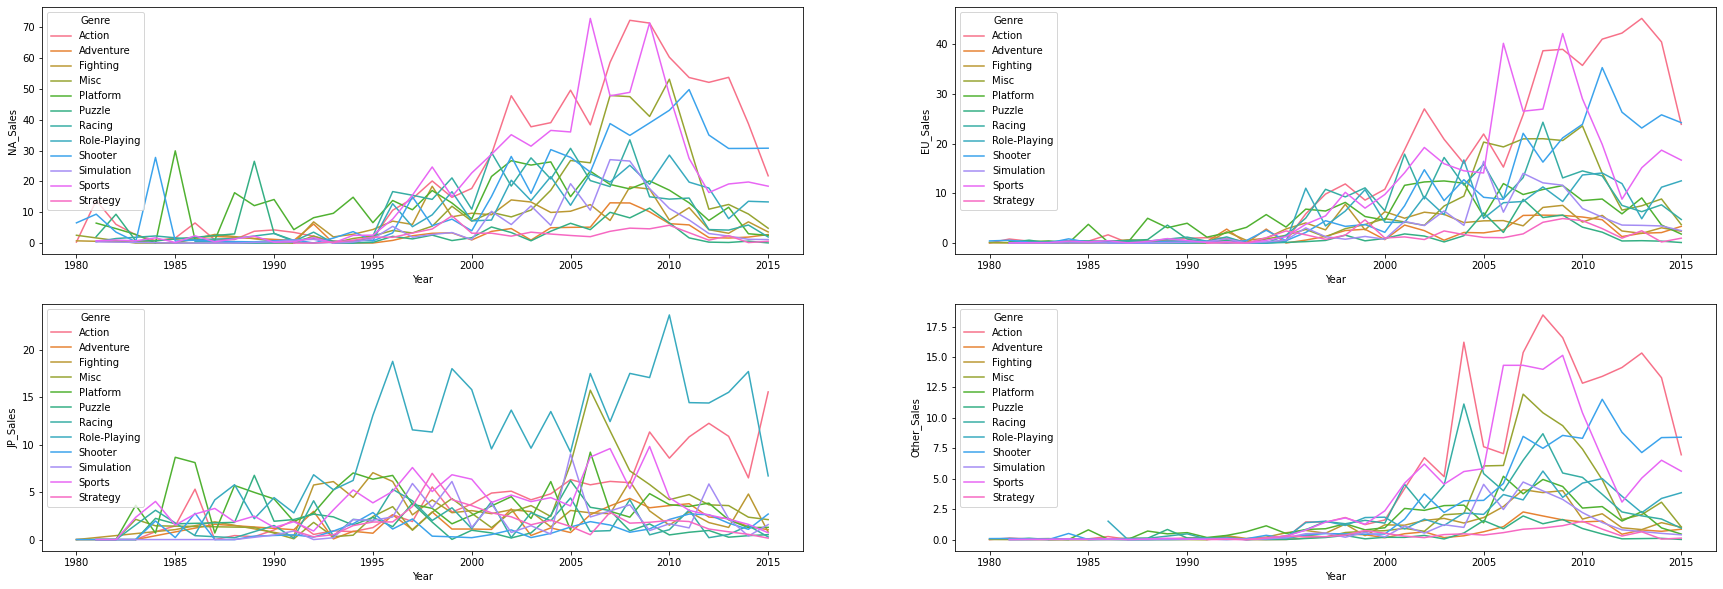

In [24]:
### 출시 연도, 장르, 지역 (sum) ###

condition = (df['Year'] > 0) & (df['Year'] < 2016)
genre_sales = df[condition]

genre_sales = genre_sales.groupby(['Genre', 'Year']).sum()
genre_sales = genre_sales.reset_index()

#시각화
fig = plt.figure(figsize = (30,10))

area01 = fig.add_subplot(2, 2, 1)
area02 = fig.add_subplot(2, 2, 2)
area03 = fig.add_subplot(2, 2, 3)
area04 = fig.add_subplot(2, 2, 4)

print('!! Y축 범례 다른 것에 유의하세요 !! \n')
sns.lineplot(x = 'Year', y = 'NA_Sales', hue = 'Genre', ax = area01, data = genre_sales)
sns.lineplot(x = 'Year', y = 'EU_Sales', hue = 'Genre', ax = area02, data = genre_sales)
sns.lineplot(x = 'Year', y = 'JP_Sales', hue = 'Genre', ax = area03, data = genre_sales)
sns.lineplot(x = 'Year', y = 'Other_Sales', hue = 'Genre', ax = area04, data = genre_sales)

**알 수 있는 것**
1. 일본의 Role-playing 사랑은 대단하다. action은 다른 지역에 비해 되려 오른다.
2. 나머지 지역 역시 shooter가 눈에 띈다. 

!! Y축 범례 다른 것에 유의하세요 !! 



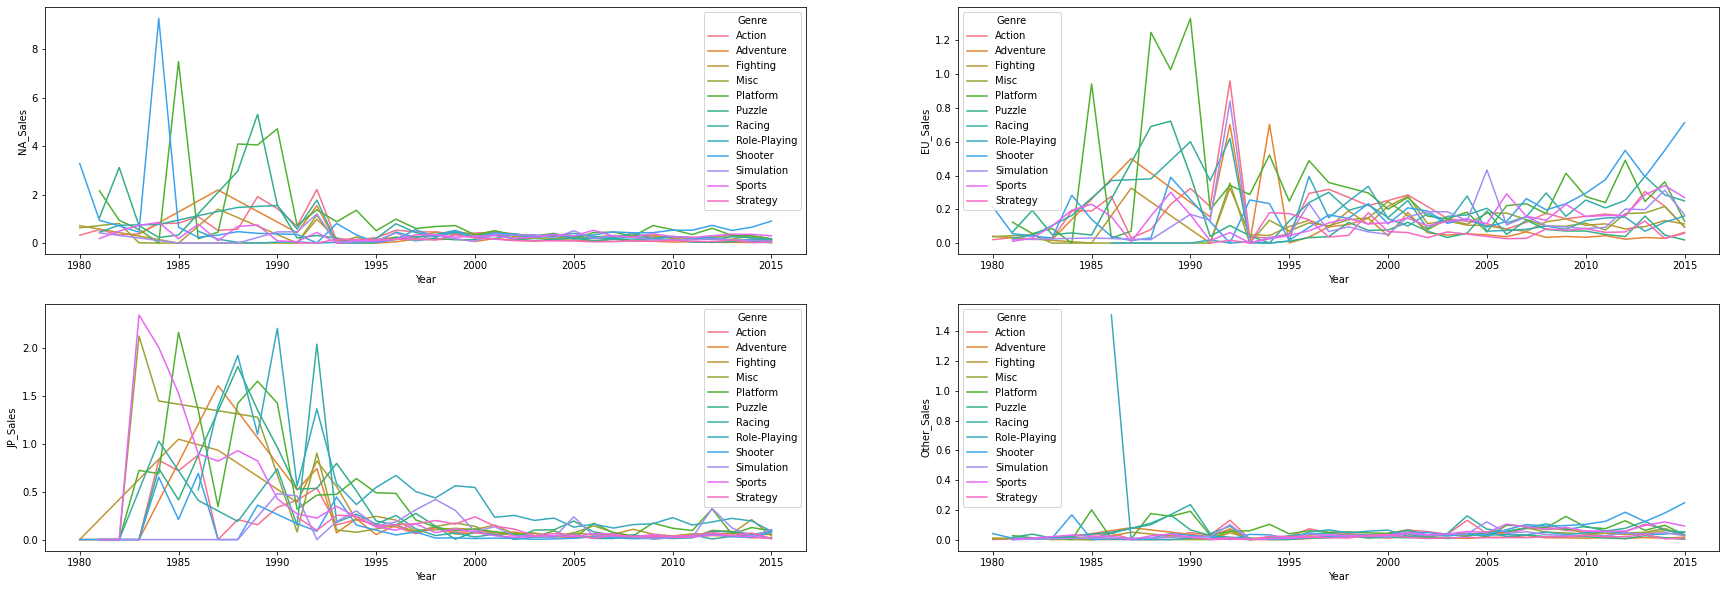

In [25]:
### 출시 연도, 장르, 지역 (mean) ###

condition = (df['Year'] > 0) & (df['Year'] < 2016)
genre_sales = df[condition]

genre_sales = genre_sales.groupby(['Genre', 'Year']).mean()
genre_sales = genre_sales.reset_index()

#시각화
fig = plt.figure(figsize = (30,10))

area01 = fig.add_subplot(2, 2, 1)
area02 = fig.add_subplot(2, 2, 2)
area03 = fig.add_subplot(2, 2, 3)
area04 = fig.add_subplot(2, 2, 4)

print('!! Y축 범례 다른 것에 유의하세요 !! \n')
sns.lineplot(x = 'Year', y = 'NA_Sales', hue = 'Genre', ax = area01, data = genre_sales)
sns.lineplot(x = 'Year', y = 'EU_Sales', hue = 'Genre', ax = area02, data = genre_sales)
sns.lineplot(x = 'Year', y = 'JP_Sales', hue = 'Genre', ax = area03, data = genre_sales)
sns.lineplot(x = 'Year', y = 'Other_Sales', hue = 'Genre', ax = area04, data = genre_sales)

!! Y축 범례 다른 것에 유의하세요 !! 



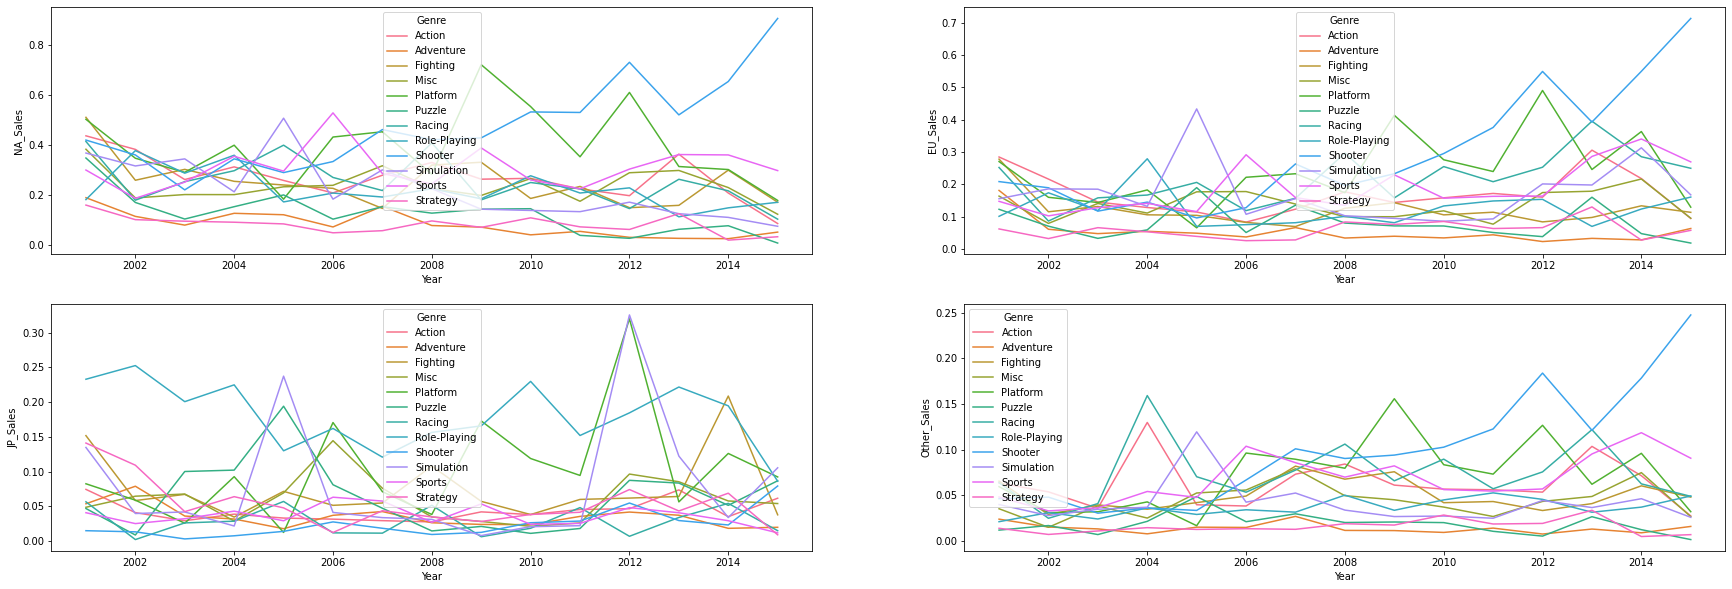

In [26]:
### 출시 연도, 장르, 지역 (mean) ###

condition = (df['Year'] > 2000) & (df['Year'] < 2016)
genre_sales = df[condition]

genre_sales = genre_sales.groupby(['Genre', 'Year']).mean()
genre_sales = genre_sales.reset_index()

#시각화
fig = plt.figure(figsize = (30,10))

area01 = fig.add_subplot(2, 2, 1)
area02 = fig.add_subplot(2, 2, 2)
area03 = fig.add_subplot(2, 2, 3)
area04 = fig.add_subplot(2, 2, 4)

print('!! Y축 범례 다른 것에 유의하세요 !! \n')
sns.lineplot(x = 'Year', y = 'NA_Sales', hue = 'Genre', ax = area01, data = genre_sales)
sns.lineplot(x = 'Year', y = 'EU_Sales', hue = 'Genre', ax = area02, data = genre_sales)
sns.lineplot(x = 'Year', y = 'JP_Sales', hue = 'Genre', ax = area03, data = genre_sales)
sns.lineplot(x = 'Year', y = 'Other_Sales', hue = 'Genre', ax = area04, data = genre_sales)

**알 수 있는 것**<br>
**shooter?!**

## **Platform**
시간의 변화에 따라 Platform의 변화는 어떠한가?

In [27]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


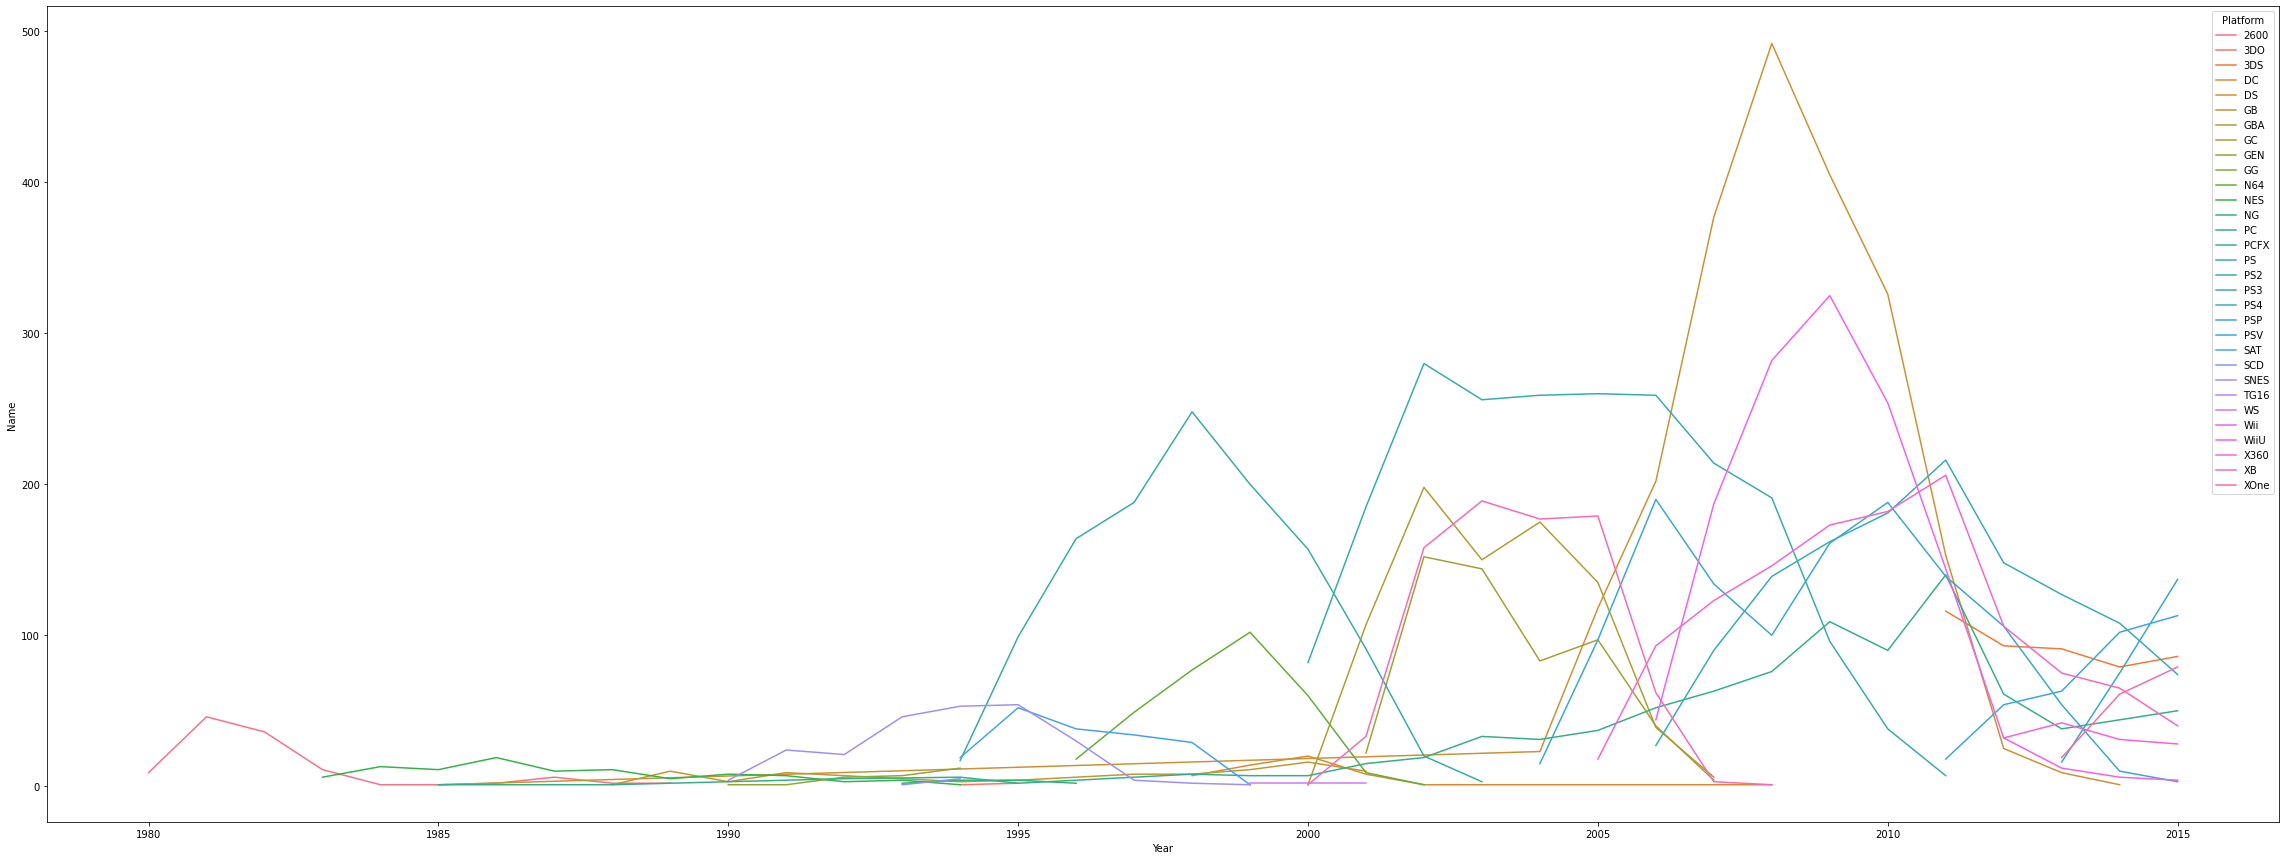

In [28]:
### Plaform 별 게임 출시 수 (출시연도별 count) ###
condition = (df['Year'] > 0) & (df['Year'] < 2016)
platform_release = df[condition]

platform_release = platform_release.groupby(['Platform', 'Year']).count()
platform_release = platform_release.reset_index()
platform_release = platform_release[['Platform', 'Year', 'Name']]
platform_release.head()

#시각화
fig = plt.figure(figsize = (40,15))
sns.lineplot(x = 'Year', y = 'Name', hue = 'Platform', data = platform_release)

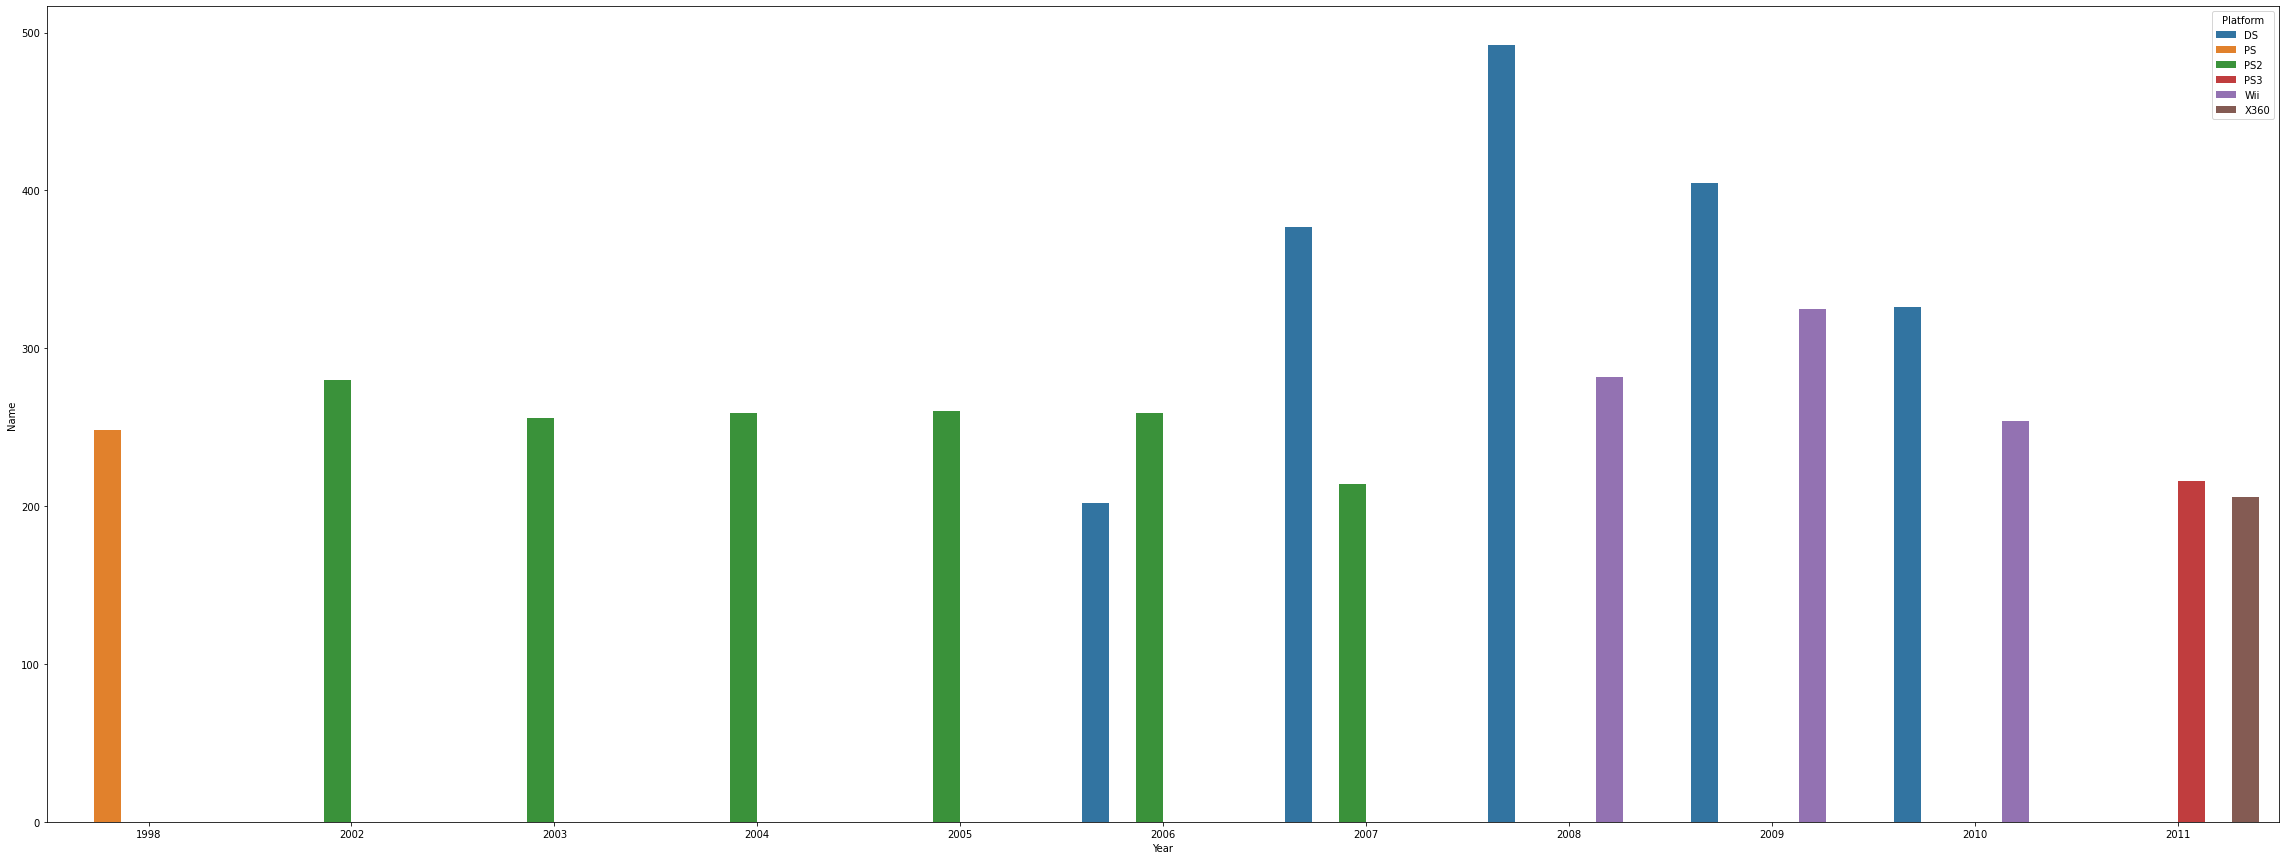

In [29]:
# 플랫폼 출시 게임 수 200개 이상만 봐보자.
condition = (platform_release['Name'] > 200)
platform_release = platform_release[condition]
platform_release

fig = plt.figure(figsize = (40,15))
sns.barplot(x = 'Year', y = 'Name', hue = 'Platform', data = platform_release)


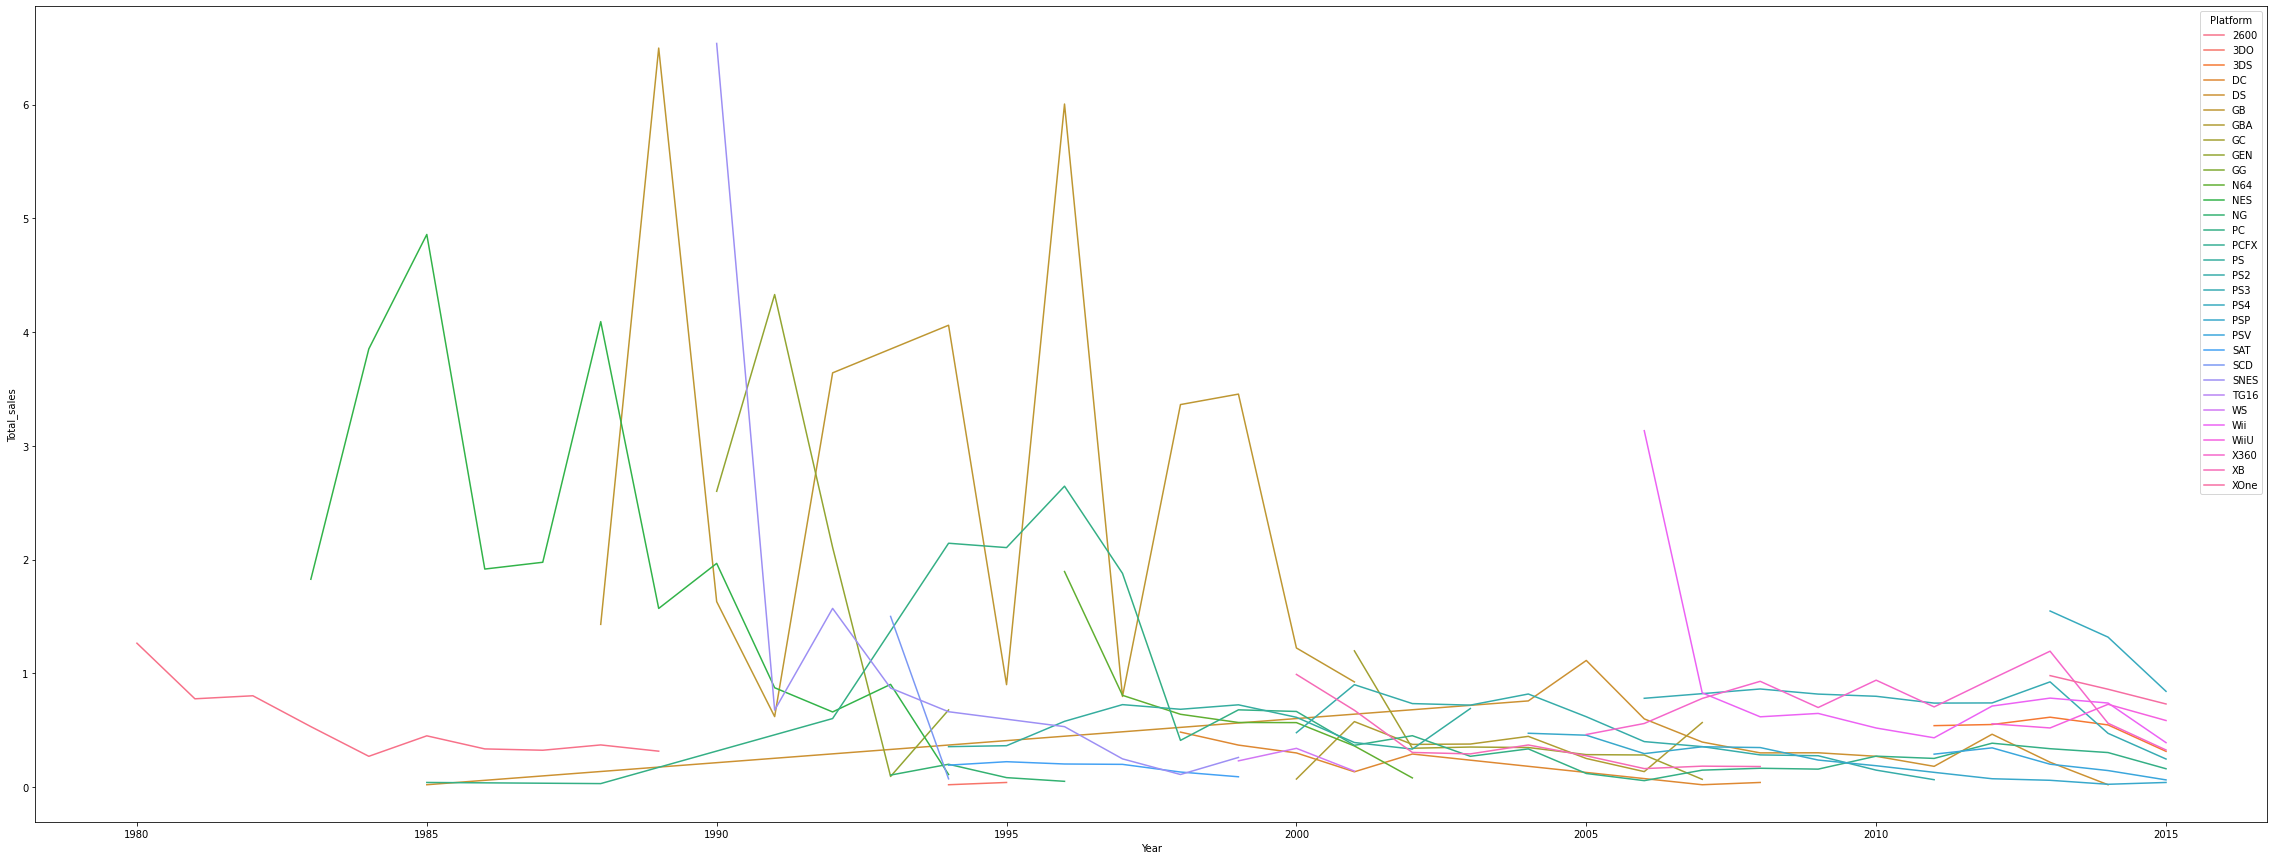

In [30]:
### Platform 별 게임 판매량 (출시연도별 mean) ### 
condition = (df['Year'] > 0) & (df['Year'] < 2016)
platform_release = df[condition]

platform_release = platform_release.groupby(['Platform', 'Year']).mean()
platform_release = platform_release.reset_index()
platform_release = platform_release[['Platform', 'Year', 'Total_sales']]
platform_release.head()

#시각화
fig = plt.figure(figsize = (40,15))
sns.lineplot(x = 'Year', y = 'Total_sales', hue = 'Platform', data = platform_release)

이것만 봐선 딱히 모르겠고, PC는 어떨까?

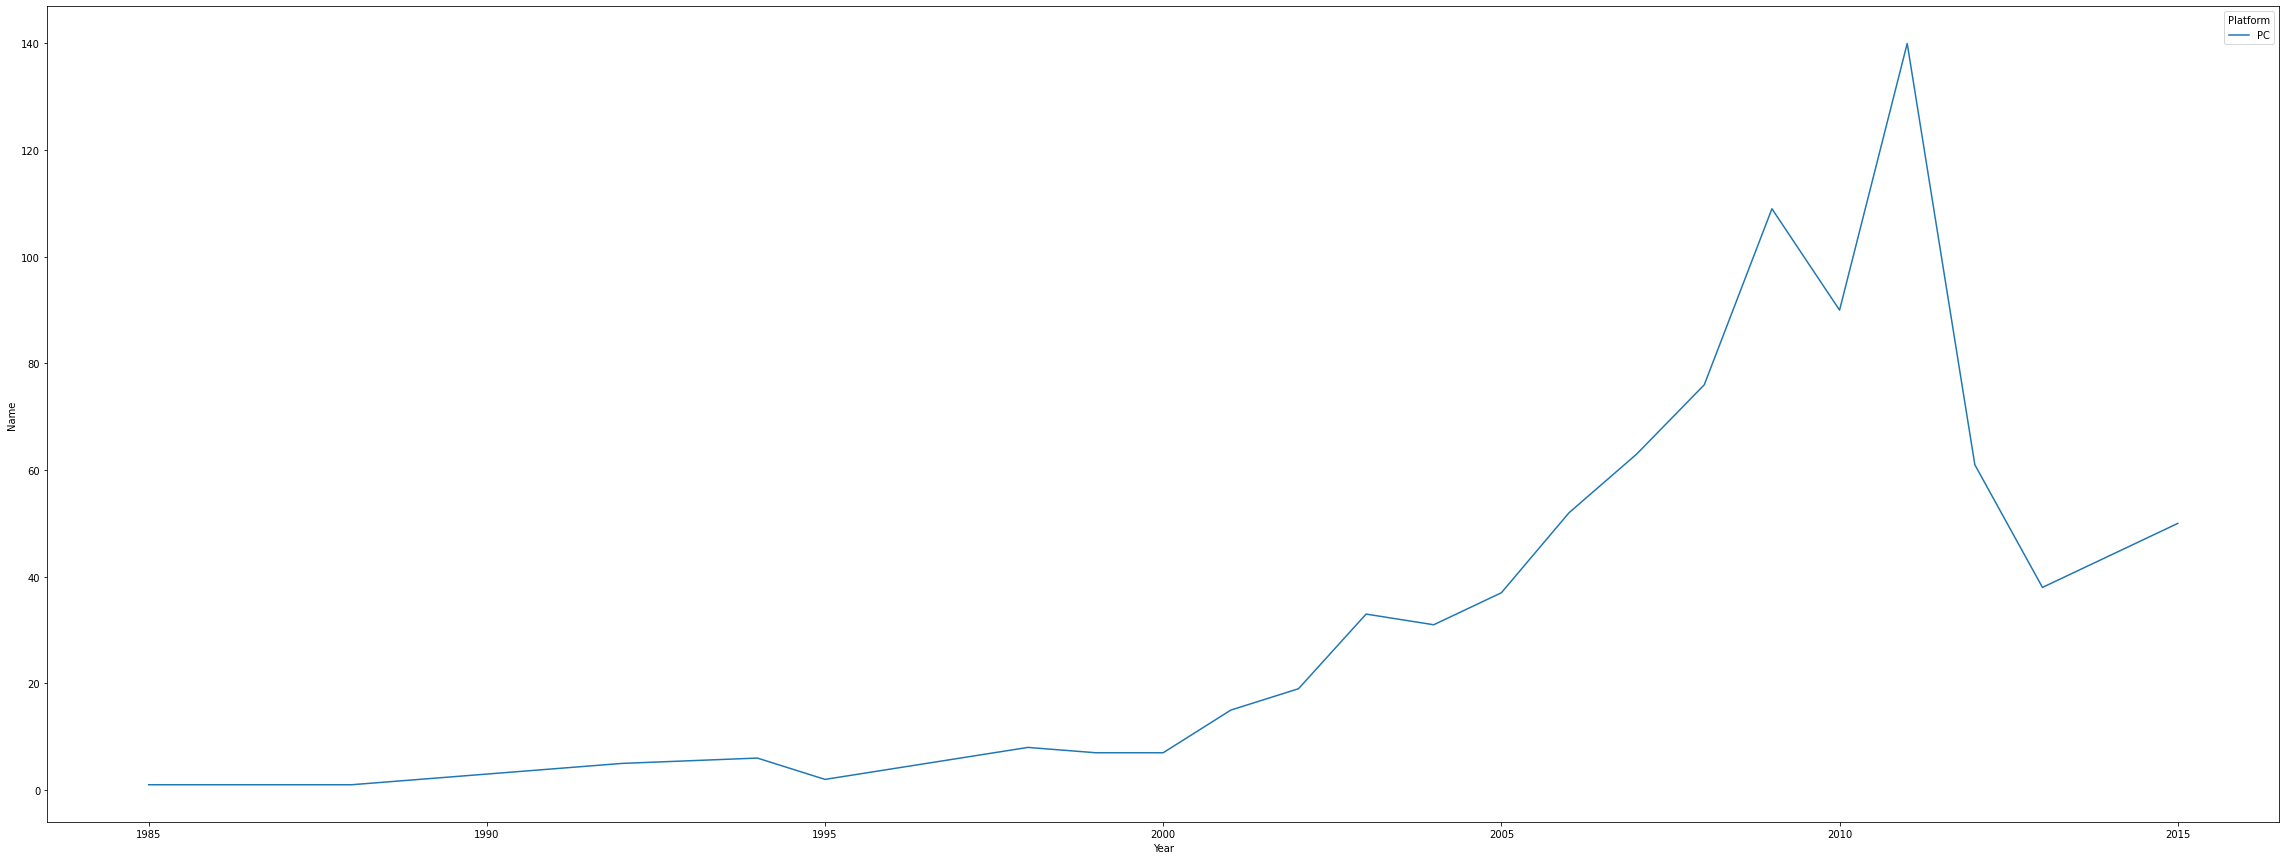

In [31]:
### PC 게임 출시 수 (출시연도별 count) ###
condition = (df['Year'] > 0) & (df['Year'] < 2016) & (df['Platform'] == 'PC')
platform_release = df[condition]

platform_release = platform_release.groupby(['Platform', 'Year']).count()
platform_release = platform_release.reset_index()
platform_release = platform_release[['Platform', 'Year', 'Name']]
platform_release

#시각화
fig = plt.figure(figsize = (40,15))
sns.lineplot(x = 'Year', y = 'Name', hue = 'Platform', data = platform_release)

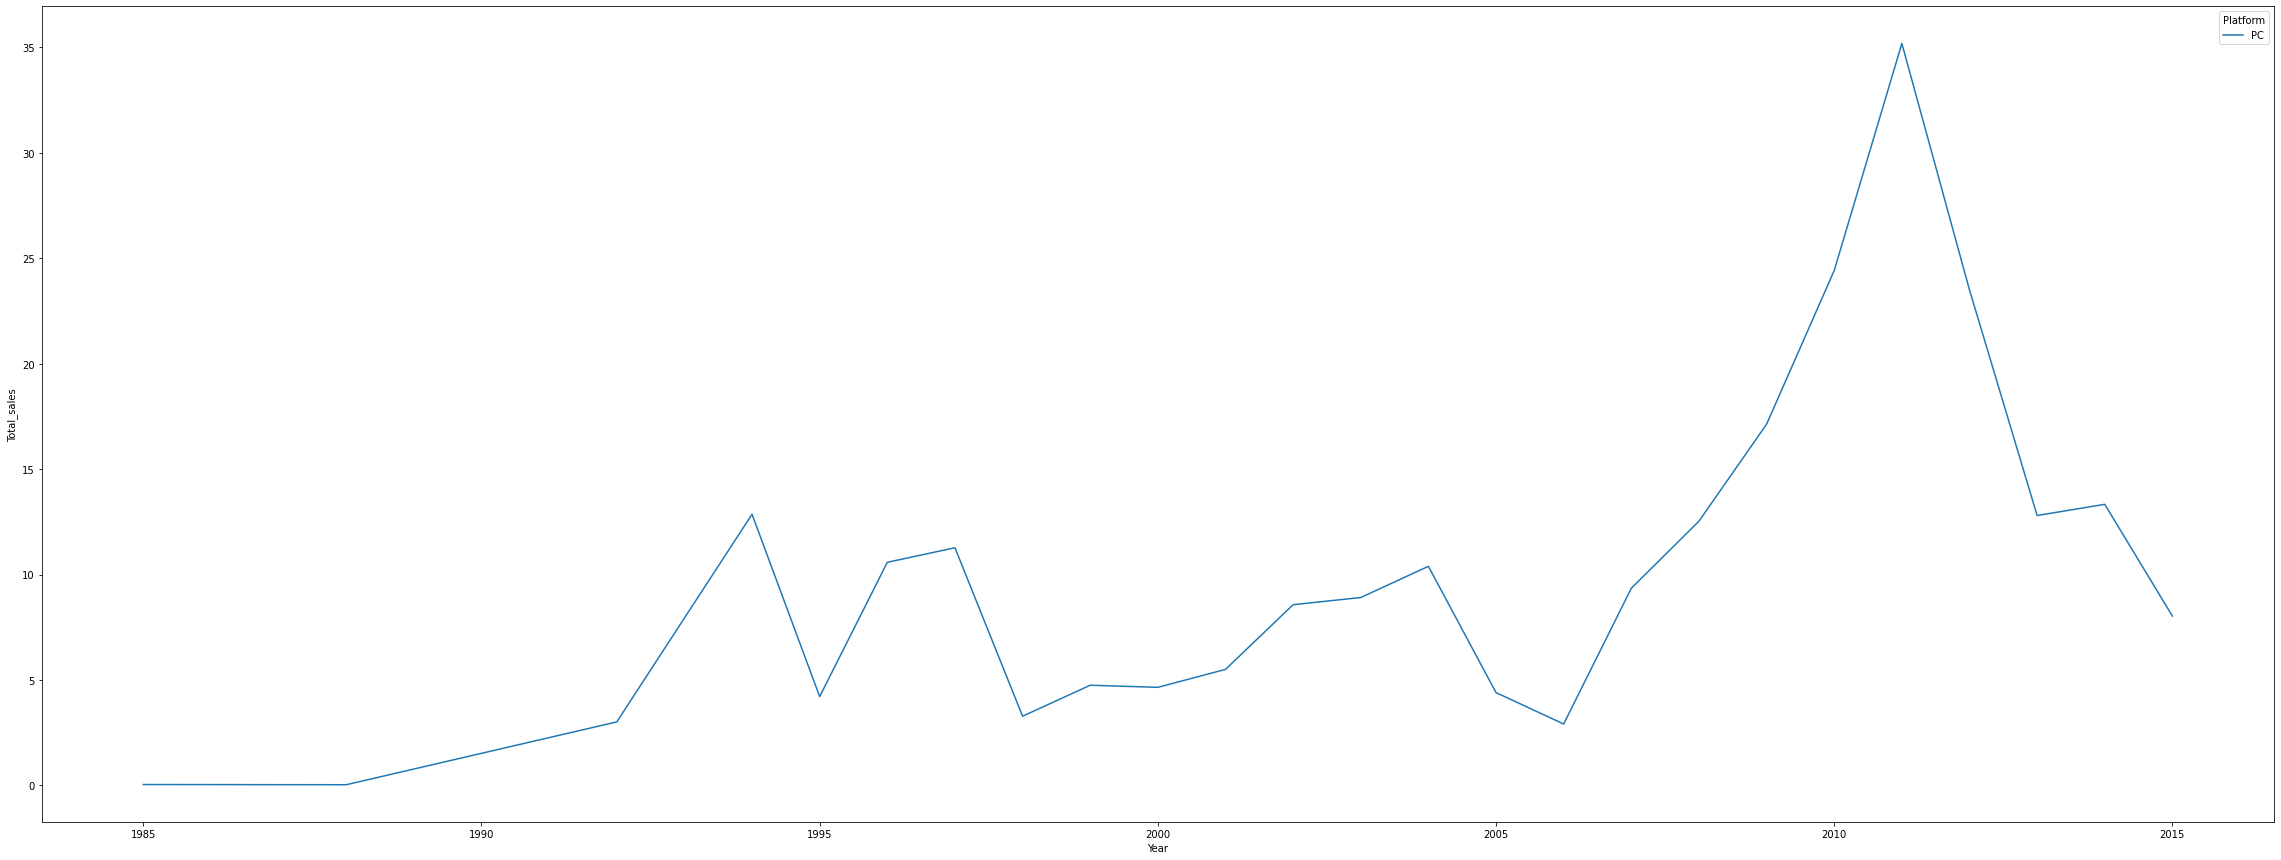

In [32]:
### PC 판매량 (출시연도별 sum) ###
condition = (df['Year'] > 0) & (df['Year'] < 2016) & (df['Platform'] == 'PC')
platform_release = df[condition]

platform_release = platform_release.groupby(['Platform', 'Year']).sum()
platform_release = platform_release.reset_index()
platform_release = platform_release[['Platform', 'Year', 'Total_sales']]
platform_release

#시각화
fig = plt.figure(figsize = (40,15))
sns.lineplot(x = 'Year', y = 'Total_sales', hue = 'Platform', data = platform_release)

**이것만 봐선 PC도 그닥 좋아보이지는 않는데**

## **판매량 TOP 10 - Publisher 기준**

**TOTAL**

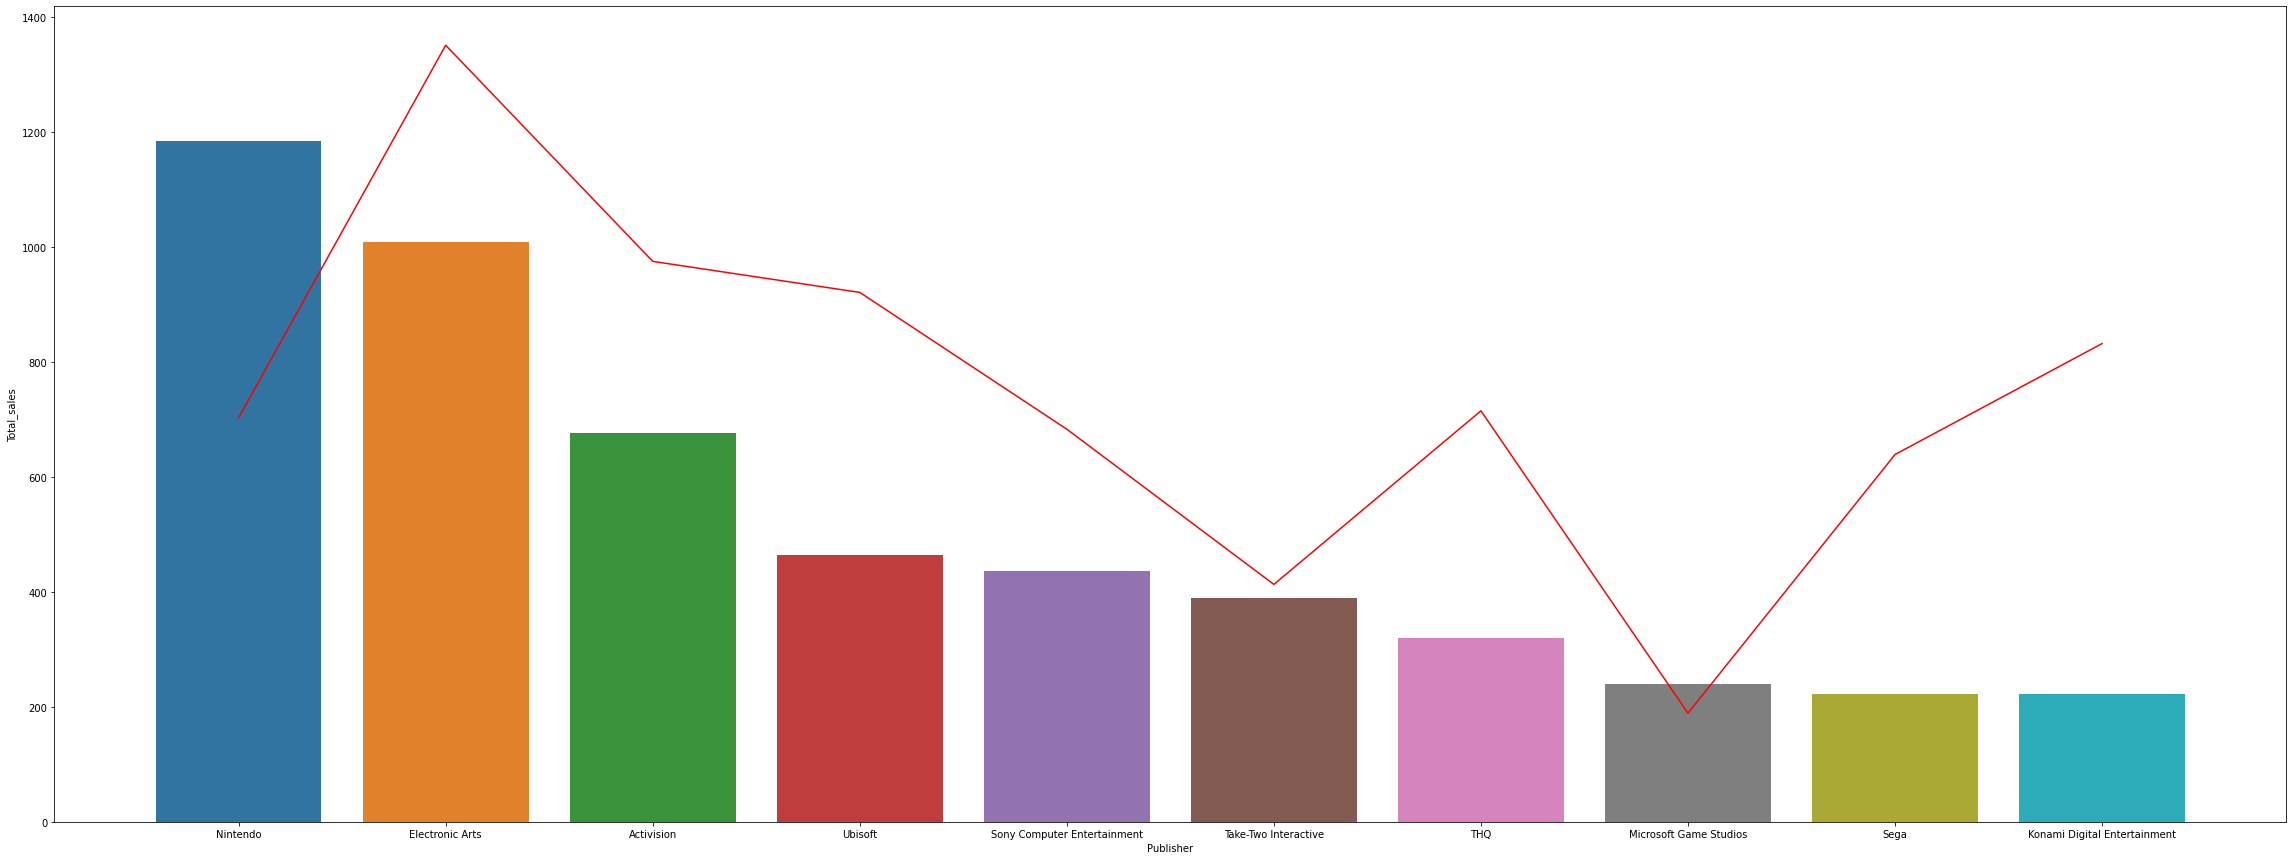

In [33]:
### 2000년 이후 Publisher 별 판매량 Top 10 & 출시 게임 수 ###
condition = (df['Year'] >= 2000)
publisher_sales = df[condition]

# 판매량 TOP 10
publisher_sales = publisher_sales.groupby(['Publisher']).sum()
publisher_sales = publisher_sales.reset_index()
publisher_sales = publisher_sales[['Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Total_sales']]
publisher_sales = publisher_sales.sort_values('Total_sales', ascending = False)
publisher_sales = publisher_sales.reset_index()
publisher_sales = publisher_sales.loc[:9, :]

# TOP10 Publicher 출시게임 수 더하기
publisher_release = df.groupby(['Publisher']).count()
publisher_release = publisher_release.reset_index()
publisher_release = publisher_release[['Publisher', 'Name']]
publisher_release.rename(columns = {'Name' : 'release_count'}, inplace = True)
publisher_release = pd.merge(publisher_sales, publisher_release, on = "Publisher")
publisher_release

# 시각화
fig = plt.figure(figsize = (40,15))
ax = sns.barplot(x = 'Publisher', y = 'Total_sales', data = publisher_release)
ax = sns.lineplot(x = 'Publisher', y = 'release_count', data = publisher_release, color = 'r')

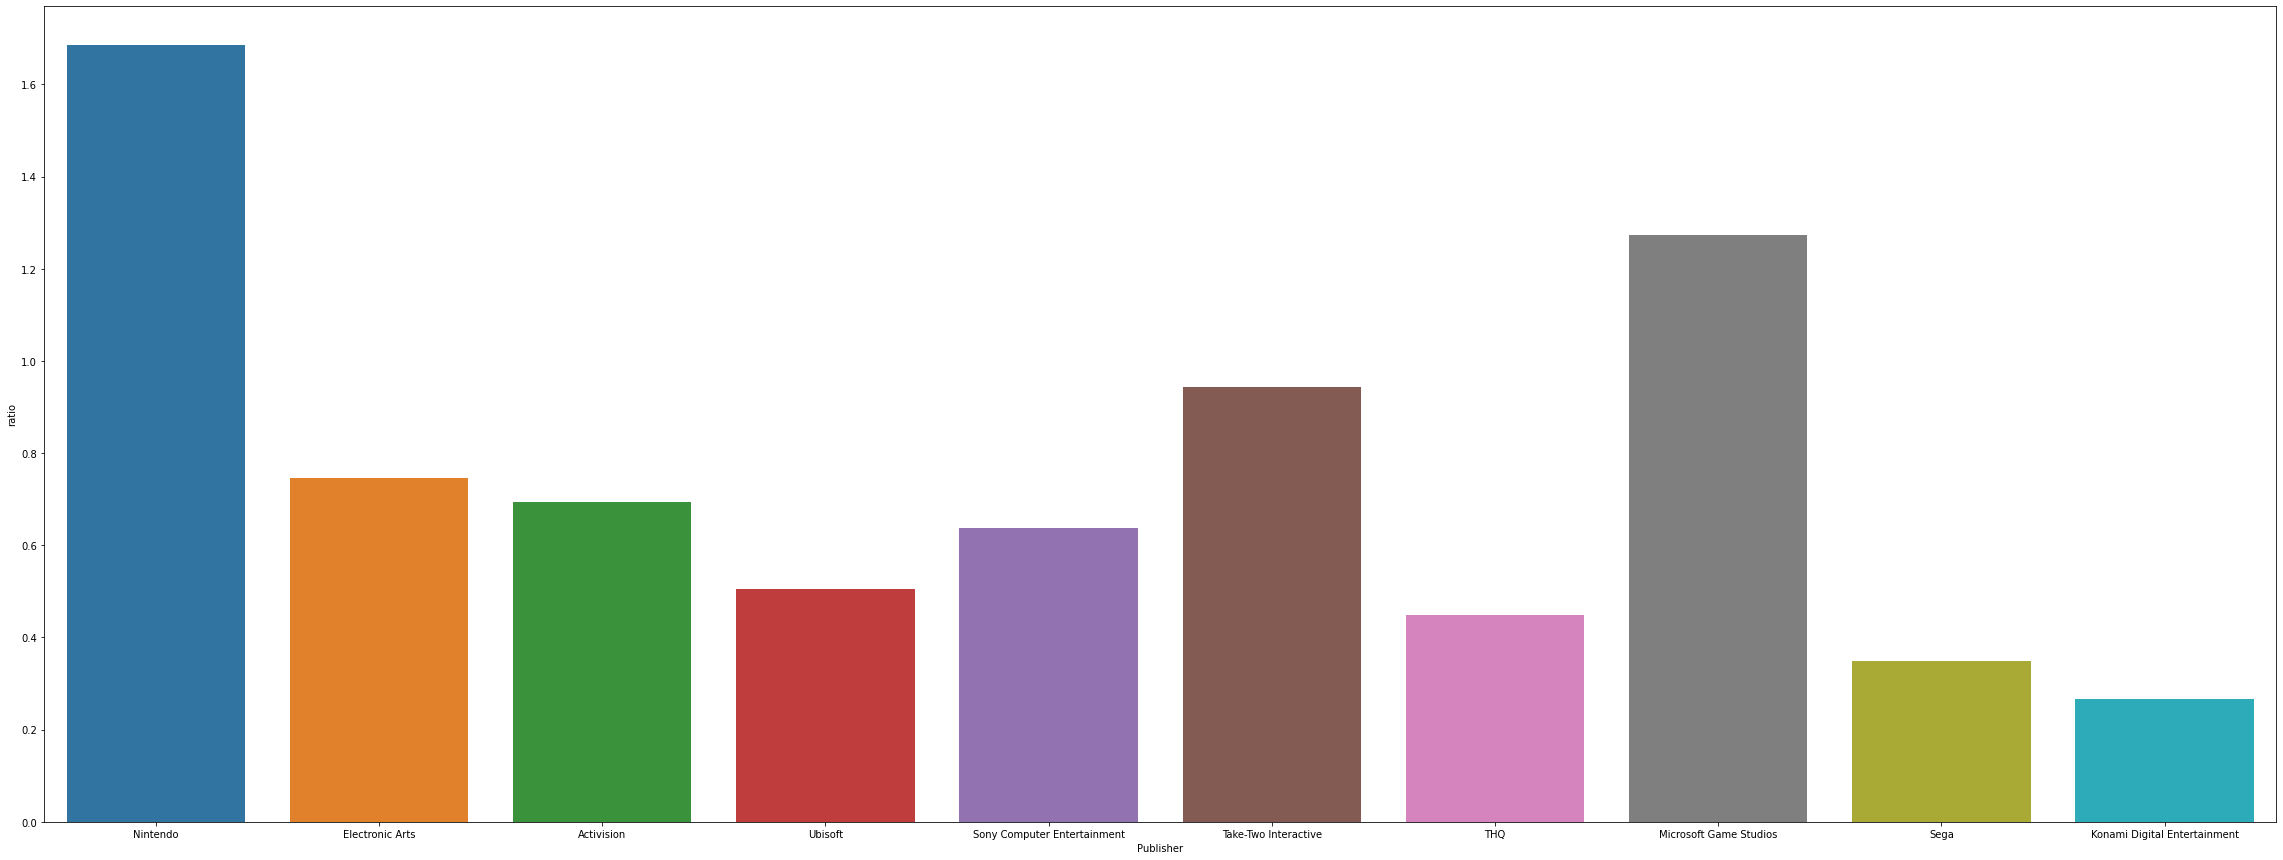

In [34]:
### 판매량 TOP10 - 출시 게임 수 대비 Total_sales 비율 ###
publisher_release['ratio'] = publisher_release['Total_sales'] / publisher_release['release_count']

# 시각화
fig = plt.figure(figsize = (40,15))
ax = sns.barplot(x = 'Publisher', y = 'ratio', data = publisher_release)

**알 수 있는 것** (2000년 이후에 대해서임)
1. 닌텐도는 게임 출시 수 대비 판매량이 다른 곳에 비해 압도적으로 높음.
  - 인기 게임이 다른 곳에 비해 많을 것이라는 걸 보여줌.
2. EA는 총 판매량은 높으나 게임 당 평균 판매량은 다른 Publisher에 비해 그닥 높지는 않음.
  - 아마 몇몇 인기게임에 총 판매량을 의존하고 있을 가능성이 보임. 
3. MS도 게임 출시에 비해 돈을 많이 번다. 
4. 나머지는 비등비등해서 일단 위 3개 먼저 타겟으로 분석해보고 필요시 추가 분석하면 될 듯.

## **판매량 TOP 10 - Total/지역별**

**TOTAL**

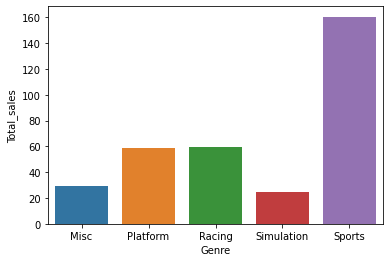

In [35]:
### 2000년 이후 판매량 Top 10 ###
condition = (df['Year'] >= 2000)
top10 = df[condition]

# 판매량 TOP 10
top10 = top10.sort_values('Total_sales', ascending = False)
top10_total = top10.head(10)

#장르 기준
top10_total = top10_total.groupby(['Genre']).sum()
top10_total = top10_total.reset_index()
sns.barplot(x = 'Genre', y = 'Total_sales', data = top10_total)

**NA**

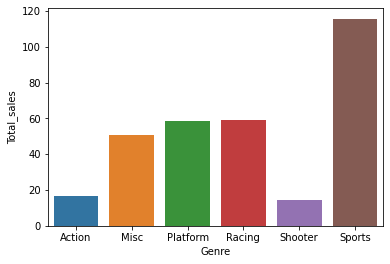

In [36]:
### 2000년 이후 판매량 Top 10 ###
condition = (df['Year'] >= 2000)
top10 = df[condition]

# 판매량 TOP 10
top10_na = top10.sort_values('NA_Sales', ascending = False)
top10_na = top10_na.head(10)

#장르 기준
top10_na = top10_na.groupby(['Genre']).sum()
top10_na = top10_na.reset_index()
sns.barplot(x = 'Genre', y = 'Total_sales', data = top10_na)

**EU**

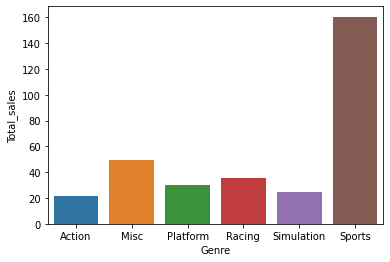

In [37]:
### 2000년 이후 판매량 Top 10 ###
condition = (df['Year'] >= 2000)
top10 = df[condition]

# 판매량 TOP 10
top10_eu = top10.sort_values('EU_Sales', ascending = False)
top10_eu = top10_eu.head(10)

#장르 기준
top10_eu = top10_eu.groupby(['Genre']).sum()
top10_eu = top10_eu.reset_index()
sns.barplot(x = 'Genre', y = 'Total_sales', data = top10_eu)

**JP**

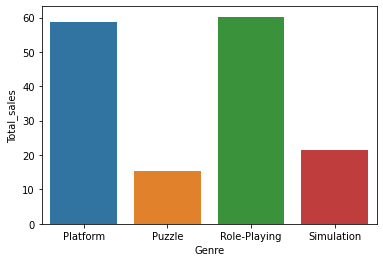

In [38]:
### 2000년 이후 판매량 Top 10 ###
condition = (df['Year'] >= 2000)
top10 = df[condition]

# 판매량 TOP 10
top10_jp = top10.sort_values('JP_Sales', ascending = False)
top10_jp = top10_jp.head(10)

#장르 기준
top10_jp = top10_jp.groupby(['Genre']).sum()
top10_jp = top10_jp.reset_index()
sns.barplot(x = 'Genre', y = 'Total_sales', data = top10_jp)

**알수 있는 것 (2000년 이후)** <br>
- 일본을 제외하고는 판매량 기준 Sport가 가장 많음. 
- 일본은 Platform, Role-Playing 비중이 가장 높아 나머지 지역과는 차이가 있음.

# **Go-to-Market**
(대략적인 트렌드 파악을 통해 세운 가설 검증을 통한 go-to-market 전략 수립)



---



**우리가 다음 분기에 어떤 게임을 만들어야 가장 많이 팔 수 있을지 알기 위해 정해야 하는 것은 아래 두 가지이다.**

1. **`어느 지역`을 타겟으로 할 것인가?**
2. **`어떤 장르`를 만들 것인가?**

*(Publisher, Platform은 우리가 해당 제작사가 아니기 때문에 정할 필요가 없으며, 위 두가지를 보다 잘 결정하는데에 참고만 하면 된다.)*
<br>
<br>

**모든 분석은 2009년 이후를 기간으로 한다.**
- 최근 트렌드에 맞추어 가장 많이 팔 수 있는 게임을 찾아야 하므로.
- 출시 게임 수, 판매량 합계가 (모바일 시장의 열림으로 인해) 전반적으로 변화하는 변곡점으로 판단되므로.

---




아래와 같은 가설을 세웠다. 

1. 북미 지역의 판매량 평균은 다른 지역에 비해 높을 것이다.  
2. 북미 지역에서는 최근 가장 선호도가 높은 Shooter 장르가 적합할 것이다.

이에대한 T-test 검정 실시.

In [39]:
# 2009년 이후 데이터셋
condition = (df['Year'] >= 2009) & (df['Year'] <= 2016)
df2 = df[condition]
df2.head()

#library
from scipy import stats

In [40]:
#!pip install scipy --upgrade

## **북미 지역의 판매량 평균은 다른 지역에 비해 높을 것이다.**
1. 북미 - EU
    - 귀무가설:  평균 북미 판매량이 EU보다 작거나 같다.
    - 대립가설: 평균 북미 판매량이 EU보다 크다.
2. 북미 - JP
    - 귀무가설:  평균 북미 판매량이 JP보다 작거나 같다.
    - 대립가설: 평균 북미 판매량이 JP보다 크다.
3. 북미 - 기타 지역
    - 귀무가설:  평균 북미 판매량이 기타 지역보다 작거나 같다.
    - 대립가설: 평균 북미 판매량이 기타 지역보다 크다.

In [47]:
### 북미 - EU ###
res = stats.ttest_ind(df2['NA_Sales'], df2['EU_Sales'], alternative = 'greater').pvalue
print(res)
print('북미 - EU: 대립가설 채택')

### 북미 - JP ###
res2 = stats.ttest_ind(df2['NA_Sales'], df2['JP_Sales'], alternative = 'greater').pvalue
print(res2)
print('북미 - JP: 대립가설 채택')

### 북미 - 기타지역 ###
res3 = stats.ttest_ind(df2['NA_Sales'], df2['Other_Sales'], alternative = 'greater').pvalue
print(res3)
print('북미 - 기타: 대립가설 채택')

6.825973752148234e-11
북미 - EU: 대립가설 채택
2.7031062688520844e-83
북미 - JP: 대립가설 채택
2.0999962542191533e-91
북미 - 기타: 대립가설 채택


## **북미 지역에서는 최근 가장 선호도가 높은 Shooter 장르가 적합할 것이다.**

(Shooter - RolePlaying/Adventure/Racing/Platform/Simulation/Fighting/Strategy/Puzzle)
<br>
<br>

- 귀무가설: 북미지역 평균 Shooter 장르 판매량이 ...보다 작거나 같다.
- 대립가설: 북미지역 평균 Shooter 장르 판매량이 ...보다 크다.

In [54]:
## 데이터셋 준비 ##

shooter_df = df2[(df2['Genre'] == 'Shooter')]
action_df = df2[(df2['Genre'] == 'Action')]
sports_df = df2[(df2['Genre'] == 'Sports')]
misc_df = df2[(df2['Genre'] == 'Misc')]
roleplaying_df = df2[(df2['Genre'] == 'Role-Playing')]
adventure_df = df2[(df2['Genre'] == 'Adventure')]
racing_df = df2[(df2['Genre'] == 'Racing')]
platform_df = df2[(df2['Genre'] == 'Platform')]
simulation_df = df2[(df2['Genre'] == 'Simulation')]
fighting_df = df2[(df2['Genre'] == 'Fighting')]
strategy_df = df2[(df2['Genre'] == 'Strategy')]
puzzle_df = df2[(df2['Genre'] == 'Puzzle')]

In [58]:
# shooter - action
a1 = stats.ttest_ind(shooter_df['NA_Sales'], action_df['NA_Sales'], alternative = 'greater').pvalue
print(a1)
print('shooter - action: 대립가설 채택')

# shooter - sports
a2 = stats.ttest_ind(shooter_df['NA_Sales'], sports_df['NA_Sales'], alternative = 'greater').pvalue
print(a2)
print('shooter - sports: 대립가설 채택')

# shooter - misc
a3 = stats.ttest_ind(shooter_df['NA_Sales'], misc_df['NA_Sales'], alternative = 'greater').pvalue
print(a3)
print('shooter - misc: 대립가설 채택')

# shooter - roleplaying
a4 = stats.ttest_ind(shooter_df['NA_Sales'], roleplaying_df['NA_Sales'], alternative = 'greater').pvalue
print(a4)
print('shooter - roleplaying: 대립가설 채택')

# shooter - adventure
a5 = stats.ttest_ind(shooter_df['NA_Sales'], adventure_df['NA_Sales'], alternative = 'greater').pvalue
print(a5)
print('shooter - adventure: 대립가설 채택')

# shooter - racing
a6 = stats.ttest_ind(shooter_df['NA_Sales'], racing_df['NA_Sales'], alternative = 'greater').pvalue
print(a6)
print('shooter - racing: 대립가설 채택')

# shooter - simulation
a8 = stats.ttest_ind(shooter_df['NA_Sales'], simulation_df['NA_Sales'], alternative = 'greater').pvalue
print(a8)
print('shooter - simulation: 대립가설 채택')

# shooter - fighting
a9 = stats.ttest_ind(shooter_df['NA_Sales'], fighting_df['NA_Sales'], alternative = 'greater').pvalue
print(a9)
print('shooter - fighting: 대립가설 채택')

# shooter - strategy
a10 = stats.ttest_ind(shooter_df['NA_Sales'], strategy_df['NA_Sales'], alternative = 'greater').pvalue
print(a10)
print('shooter - strategy: 대립가설 채택')

# shooter - puzzle
a11 = stats.ttest_ind(shooter_df['NA_Sales'], puzzle_df['NA_Sales'], alternative = 'greater').pvalue
print(a11)
print('shooter - puzzle: 대립가설 채택')


# shooter - platform
a7 = stats.ttest_ind(shooter_df['NA_Sales'], platform_df['NA_Sales'], alternative = 'greater').pvalue
print('================================')
print(a7)
print('shooter - platform: 귀무가설 채택')


1.6388152140262083e-19
shooter - action: 대립가설 채택
8.899249450179367e-06
shooter - sports: 대립가설 채택
1.0795804741764621e-09
shooter - misc: 대립가설 채택
6.728893416297661e-12
shooter - roleplaying: 대립가설 채택
3.2009781485182372e-25
shooter - adventure: 대립가설 채택
4.4960540165302196e-07
shooter - racing: 대립가설 채택
1.0949279984551877e-09
shooter - simulation: 대립가설 채택
3.234758321013598e-05
shooter - fighting: 대립가설 채택
5.680538382528359e-09
shooter - strategy: 대립가설 채택
4.3511414628358847e-07
shooter - puzzle: 대립가설 채택
0.1230334324973793
shooter - platform: 귀무가설 채택


In [71]:
# Platform 장르 어느 publisher가 많을까?
platform_df2 = platform_df.groupby('Publisher').count()
platform_df2 = platform_df2.sort_values('Name', ascending = False)
platform_df2 = platform_df2.head(5)
platform_df2

,Name,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
Publisher,,,,,,,,,
Ubisoft,26,26,26,26,26,26,26,26,26
Nintendo,22,22,22,22,22,22,22,22,22
Sony Computer Entertainment,18,18,18,18,18,18,18,18,18
Activision,15,15,15,15,15,15,15,15,15
Sega,13,13,13,13,13,13,13,13,13


In [79]:
# platform 장르 ubisoft 판매 상위 게임 리스트
platform_df3 = platform_df[(platform_df['Publisher'] == 'Ubisoft')]
platform_df3 = platform_df3.sort_values('NA_Sales', ascending = False)
platform_df3 = platform_df3.head(5)
platform_df3

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
13168,Rayman Origins,X360,2011,Platform,Ubisoft,0.38,0.34,0.00,0.08,0.80
12929,Rabbids Go Home,DS,2009,Platform,Ubisoft,0.35,0.30,0.00,0.07,0.72
6783,Rayman Origins,PS3,2011,Platform,Ubisoft,0.33,0.51,0.01,0.18,1.03
6198,Rayman Legends,WiiU,2013,Platform,Ubisoft,0.26,0.33,0.03,0.06,0.68
13959,Rabbids Go Home,Wii,2009,Platform,Ubisoft,0.26,0.75,0.00,0.14,1.15


In [72]:
# Shooter 장르 어느 publisher가 많을까?
shooter_df2 = shooter_df.groupby('Publisher').count()
shooter_df2 = shooter_df2.sort_values('Name', ascending = False)
shooter_df2 = shooter_df2.head(5)
shooter_df2

,Name,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
Publisher,,,,,,,,,
Activision,86,86,86,86,86,86,86,86,86
Electronic Arts,55,55,55,55,55,55,55,55,55
Take-Two Interactive,41,41,41,41,41,41,41,41,41
Ubisoft,29,29,29,29,29,29,29,29,29
Bethesda Softworks,20,20,20,20,20,20,20,20,20


In [77]:
# shooter 장르 activision 판매 상위 게임 리스트
shooter_df3 = shooter_df[(shooter_df['Publisher'] == 'Activision')]
shooter_df3 = shooter_df3.sort_values('NA_Sales', ascending = False)
shooter_df3 = shooter_df3.head(5)
shooter_df3

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_sales
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
6236,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8.52,3.63,0.08,1.29,13.52
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
5604,Call of Duty: Ghosts,X360,2013,Shooter,Activision,6.72,2.63,0.04,0.82,10.21


**Shooter - Platform 보는 기간을 2013년 이후로 더 좁혀보자**

In [80]:
condition = (df['Year'] >= 2013) & (df['Year'] <= 2016)
df3 = df[condition]

shooter_df2 = df3[(df3['Genre'] == 'Shooter')]
platform_df2 = df3[(df3['Genre'] == 'Platform')]

b = stats.ttest_ind(shooter_df2['NA_Sales'], platform_df2['NA_Sales'], alternative = 'greater').pvalue
print(b)
print('shooter - platform: 대립가설 채택')



0.004051050490170527
shooter - platform: 대립가설 채택
